<a href="https://colab.research.google.com/github/vhppacheco/ic-ita-finance-ia/blob/main/clustering/clustering_modeling_v10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libs

In [1133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1134]:
!pip install -q yfinance
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install sqldf
!pip install -q tsfeatures
!pip install umap-learn
!pip install Riskfolio-Lib
#!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
riskfolio-lib 3.3.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1135]:
import requests
import pandas as pd
from time import sleep
import yfinance as yf
from bs4 import BeautifulSoup
#from selenium import webdriver
import json
import sys
import datetime

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from math import sqrt

sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
#chrome_options = webdriver.ChromeOptions()
#chrome_options.add_argument('--headless')
#chrome_options.add_argument('--no-sandbox')
#chrome_options.add_argument('--disable-dev-shm-usage')
#wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

# Concatenado (S&P & Ibov)

##Reading data

In [1622]:
df_ibov = pd.read_excel('/content/drive/MyDrive/IC ITA/df_Ibov_Final.xlsx')
df_ibov['Indice'] = 'Ibov'
df_ibov = df_ibov.rename(columns={'Sharpe':'Sharpe Ibov'})
df_ibov = df_ibov.rename(columns={'Beta':'Beta Ibov'})

df_sp500 = pd.read_excel('/content/drive/MyDrive/IC ITA/df_SP500_Final.xlsx')
df_sp500['Indice'] = 'S&P500'
df_sp500 = df_sp500.rename(columns={'Sharpe':'Sharpe SP500'})
df_sp500 = df_sp500.rename(columns={'Beta':'Beta sp500'})

df_indicators = pd.concat([df_sp500,df_ibov])

df_indicators = df_indicators.loc[df_indicators['Código']!='BRAP4']

##EDA

In [1623]:
df_indicators.isnull().sum()

Data                                                                  0
 LiqCor  consolid:sim*                                                0
 LiqSec  consolid:sim*                                                0
 Exig / PL  consolid:sim*                                             0
 DivBr/Ebitda  de 3 meses  consolid:sim*                              0
 Margem Liquida  de 3 meses  consolid:sim*                            0
ROA de 3 meses                                                        0
ROE de 3 meses                                                        0
P/L de 3 meses ajust pela infl                                        0
Valor Mercado da empresa Em US Dollars em milhares                    0
 Patrim Liq  Em US Dollars  em milhares  consolid:sim*                0
Price/Book ratio                                                      0
EV Em US Dollars em milhares consolid:sim*                            0
EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*            

In [1624]:
#Cria as colunas de sharpe ratio e beta unindo o sp500 e ibov
df_indicators['Sharpe Ratio'] = df_indicators['Sharpe Ibov'].fillna(0) + df_indicators['Sharpe SP500'].fillna(0)
df_indicators['Beta'] = df_indicators['Beta Ibov'].fillna(0) + df_indicators['Beta sp500'].fillna(0)
df_indicators.drop(['Sharpe Ibov','Sharpe SP500','Beta Ibov','Beta sp500'],axis='columns',inplace=True)

In [1625]:
df_indicators.isna().sum()

Data                                                              0
 LiqCor  consolid:sim*                                            0
 LiqSec  consolid:sim*                                            0
 Exig / PL  consolid:sim*                                         0
 DivBr/Ebitda  de 3 meses  consolid:sim*                          0
 Margem Liquida  de 3 meses  consolid:sim*                        0
ROA de 3 meses                                                    0
ROE de 3 meses                                                    0
P/L de 3 meses ajust pela infl                                    0
Valor Mercado da empresa Em US Dollars em milhares                0
 Patrim Liq  Em US Dollars  em milhares  consolid:sim*            0
Price/Book ratio                                                  0
EV Em US Dollars em milhares consolid:sim*                        0
EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*              0
P/FCF Em US Dollars de 3 meses consolid:sim*    

In [1626]:
#Cria a coluna Código ajustado, que tem o ".SA" no final do ticker das ações brasileiras
df_indicators['Código ajustado']=df_indicators['Código']
df_indicators.loc[df_indicators['Indice']=='Ibov','Código ajustado'] = df_indicators.loc[df_indicators['Indice']=='Ibov','Código ajustado']+str('.SA')

In [1627]:
df_indicators.sort_values(by='Sharpe Ratio',ascending=False).head(10) 

,Data,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,Valor Mercado da empresa Em US Dollars em milhares,...,Volatilidade base trimestral 3 meses Em moeda orig,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Data do Bal consolid:sim*,Código,Setor NAICS,Indice,Sharpe Ratio,Beta,Código ajustado
1697,2T2020,1.171241,0.793256,4.741137,15.680451,0.012311,0.002242,0.012874,319.899453,4.463321e+06,...,0.473970,0.100794,-0.145854,2020-06-30,VIIA3,Comércio varejista,Ibov,126.037491,1.530518,VIIA3.SA
253,2T2019,0.826152,1.627830,6.147602,8.758159,0.057867,0.003896,0.027849,86.624658,2.660698e+06,...,0.425204,0.092832,-0.173913,2019-06-30,BPAN4,Serviços financeiros e seguros,Ibov,87.108130,0.799509,BPAN4.SA
233,2T2020,1.090801,0.781532,7.880433,14.454332,0.201766,0.004377,0.038870,68.123789,1.563549e+07,...,0.374168,0.078586,-0.180000,2020-06-30,BPAC11,Serviços financeiros e seguros,Ibov,51.532180,1.590610,BPAC11.SA
1134,3T2017,1.105365,0.654432,5.900982,6.417938,0.032379,0.015551,0.107317,137.034134,4.427051e+06,...,0.348765,0.072584,-0.079592,2017-09-30,MGLU3,Comércio varejista,Ibov,47.247596,1.256333,MGLU3.SA
65,2T2020,2.104166,1.823111,1.952323,42.783600,-0.030654,-0.004536,-0.013393,-750.806848,1.022858e+07,...,0.415859,0.089988,-0.098218,2020-06-30,AMER3,Comércio varejista,Ibov,42.446056,0.873193,AMER3.SA
1758,3T2017,2.267484,2.267484,0.522348,3.830376,0.184755,0.033976,0.051724,64.183647,3.024822e+06,...,0.214633,0.045551,-0.095588,2017-09-30,YDUQ3,Educacão,Ibov,42.272584,1.102685,YDUQ3.SA
261,2T2021,0.765141,1.627830,6.678682,8.758159,0.073872,0.004744,0.036428,143.189126,5.796180e+06,...,0.324835,0.069080,-0.110468,2021-06-30,BPAN4,Serviços financeiros e seguros,Ibov,41.903542,1.051552,BPAN4.SA
1347,4T2016,9.816378,9.399498,0.297568,0.090572,2.519452,0.264753,0.343535,1.002528,8.786412e+04,...,0.271965,0.057758,-0.070685,2016-12-31,PRIO3,"Mineração, exploração de pedreiras e extração ...",Ibov,40.234191,1.039528,PRIO3.SA
1348,1T2017,3.672323,3.421612,0.547889,453.155963,0.053740,0.002870,0.004443,153.696119,1.919249e+05,...,0.271965,0.057758,-0.070685,2017-03-31,PRIO3,"Mineração, exploração de pedreiras e extração ...",Ibov,40.234191,1.039528,PRIO3.SA
1361,2T2020,0.733932,0.602881,1.580456,8.789388,-0.319578,-0.014984,-0.038665,-47.928341,8.735106e+05,...,0.501019,0.108426,-0.337263,2020-06-30,PRIO3,"Mineração, exploração de pedreiras e extração ...",Ibov,33.405928,1.610904,PRIO3.SA


In [1628]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12912 entries, 0 to 1775
Data columns (total 28 columns):
 #   Column                                                          Non-Null Count  Dtype         
---  ------                                                          --------------  -----         
 0   Data                                                            12912 non-null  object        
 1    LiqCor  consolid:sim*                                          12912 non-null  float64       
 2    LiqSec  consolid:sim*                                          12912 non-null  float64       
 3    Exig / PL  consolid:sim*                                       12912 non-null  float64       
 4    DivBr/Ebitda  de 3 meses  consolid:sim*                        12912 non-null  float64       
 5    Margem Liquida  de 3 meses  consolid:sim*                      12912 non-null  float64       
 6   ROA de 3 meses                                                  12912 non-null  float64

In [1629]:
#normaliza as colunas de formato float
columns = [' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig',
       'Sharpe Ratio', 'Beta']

for column in columns:
  #indicators_application[column] = indicators_application[column].loc[indicators_application[column].isnull()==False]
  #indicators_application = indicators_application[np.isfinite(indicators_application[column]) == True]
  df_indicators[column] = (df_indicators[column]-min(df_indicators[column].dropna())) /(max(df_indicators[column].dropna())-min(df_indicators[column].dropna()))

In [1630]:
best_10_sharpe = df_indicators.sort_values(by='Sharpe Ratio',ascending=False).head(10)['Código ajustado']
df_indicators.sort_values(by='Sharpe Ratio',ascending=False).head(10)

,Data,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,Valor Mercado da empresa Em US Dollars em milhares,...,Volatilidade base trimestral 3 meses Em moeda orig,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Data do Bal consolid:sim*,Código,Setor NAICS,Indice,Sharpe Ratio,Beta,Código ajustado
1697,2T2020,0.022548,0.015583,0.310960,0.118206,0.917501,0.532881,0.327435,0.032538,0.001520,...,0.306706,0.284877,0.718793,2020-06-30,VIIA3,Comércio varejista,Ibov,1.000000,0.456433,VIIA3.SA
253,2T2019,0.014977,0.033869,0.311115,0.117759,0.917596,0.534910,0.327872,0.032386,0.000901,...,0.274484,0.261911,0.664696,2019-06-30,BPAN4,Serviços financeiros e seguros,Ibov,0.700433,0.335648,BPAN4.SA
233,2T2020,0.020783,0.015326,0.311306,0.118127,0.917895,0.535500,0.328193,0.032374,0.005355,...,0.240763,0.220823,0.652960,2020-06-30,BPAC11,Serviços financeiros e seguros,Ibov,0.426670,0.466362,BPAC11.SA
1134,3T2017,0.021103,0.012541,0.311088,0.117608,0.917543,0.549212,0.330187,0.032419,0.001507,...,0.223978,0.203511,0.846547,2017-09-30,MGLU3,Comércio varejista,Ibov,0.393700,0.411129,MGLU3.SA
65,2T2020,0.043017,0.038148,0.310653,0.119956,0.917412,0.524562,0.326670,0.031839,0.003499,...,0.268310,0.253708,0.810636,2020-06-30,AMER3,Comércio varejista,Ibov,0.356751,0.347823,AMER3.SA
1758,3T2017,0.046600,0.047885,0.310495,0.117440,0.917859,0.571823,0.328567,0.032371,0.001026,...,0.135352,0.125542,0.815706,2017-09-30,YDUQ3,Educacão,Ibov,0.355416,0.385742,YDUQ3.SA
261,2T2021,0.013638,0.033869,0.311174,0.117759,0.917629,0.535950,0.328121,0.032423,0.001977,...,0.208167,0.193407,0.787017,2021-06-30,BPAN4,Serviços financeiros e seguros,Ibov,0.352576,0.377293,BPAN4.SA
1347,4T2016,0.212226,0.204153,0.310471,0.117199,0.922706,0.855018,0.337068,0.032330,0.000018,...,0.173233,0.160751,0.863719,2016-12-31,PRIO3,"Mineração, exploração de pedreiras e extração ...",Ibov,0.339731,0.375307,PRIO3.SA
1348,1T2017,0.077423,0.073173,0.310498,0.146458,0.917587,0.533651,0.327190,0.032430,0.000054,...,0.173233,0.160751,0.863719,2017-03-31,PRIO3,"Mineração, exploração de pedreiras e extração ...",Ibov,0.339731,0.375307,PRIO3.SA
1361,2T2020,0.012953,0.011412,0.310612,0.117761,0.916812,0.511741,0.325934,0.032298,0.000288,...,0.324578,0.306888,0.349756,2020-06-30,PRIO3,"Mineração, exploração de pedreiras e extração ...",Ibov,0.287186,0.469715,PRIO3.SA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


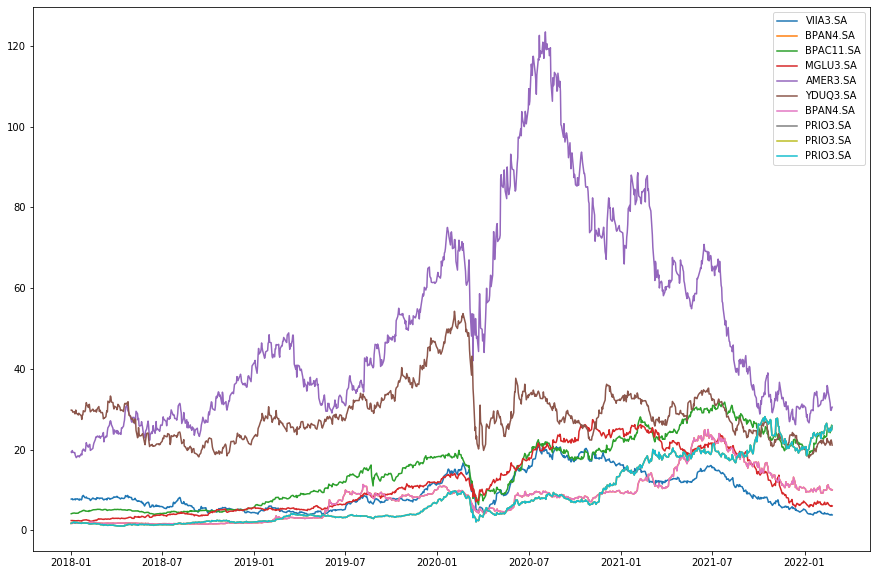

In [1631]:
for i in range(0,len(best_10_sharpe)):
  plt.plot(pd.DataFrame(yf.download(best_10_sharpe.iloc[i], start = '2018-01-01', end = '2022-02-28')['Adj Close']),label=str(best_10_sharpe.iloc[i]))
  plt.legend()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


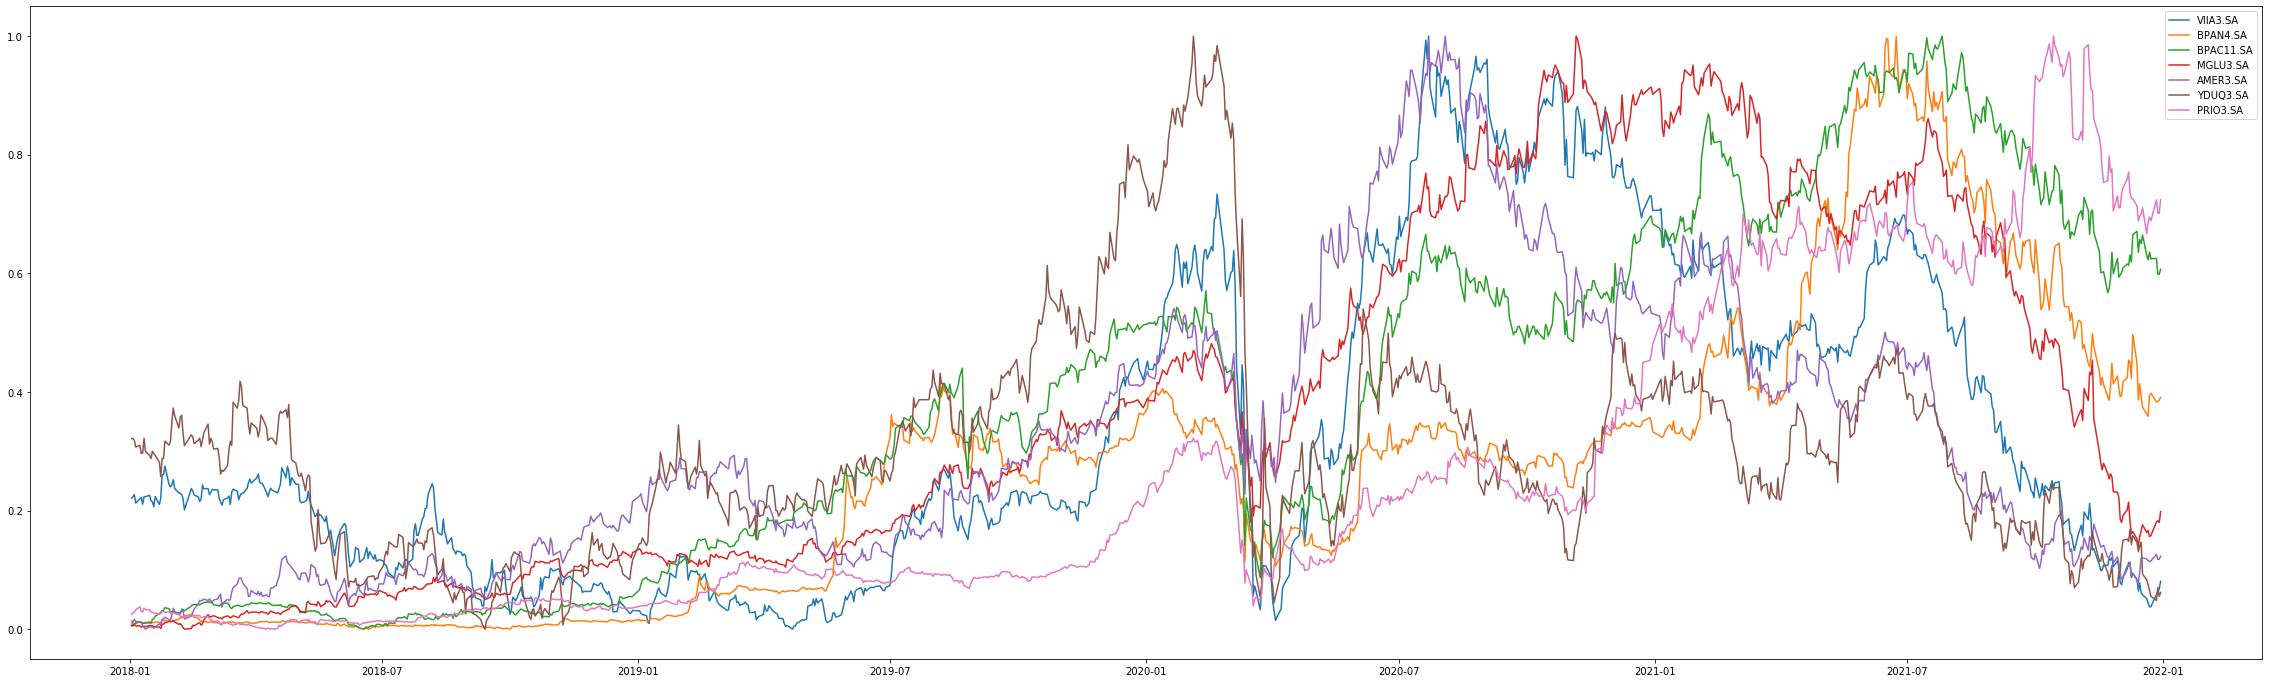

In [1632]:
for i in range(0,len(best_10_sharpe)):
  if i == 0:
    best_10 = pd.DataFrame(yf.download(best_10_sharpe.iloc[i], start = '2018-01-01', end = '2021-12-31')['Adj Close']).rename(columns={'Adj Close':best_10_sharpe.iloc[i]})
  else:
    best_10[str(best_10_sharpe.iloc[i])] = pd.DataFrame(yf.download(best_10_sharpe.iloc[i], start = '2018-01-01', end = '2021-12-31')['Adj Close']).rename(columns={'Adj Close':best_10_sharpe.iloc[i]})

for column in best_10.columns:
  best_10[column] = (best_10[column]-min(best_10[column])) /(max(best_10[column])-min(best_10[column]))

rcParams['figure.figsize'] = 40,12
for i in range(0,len(best_10.columns)):
  plt.plot(best_10.iloc[:,i],label=best_10.columns[i])
  plt.legend()

[*********************100%***********************]  1 of 1 completed


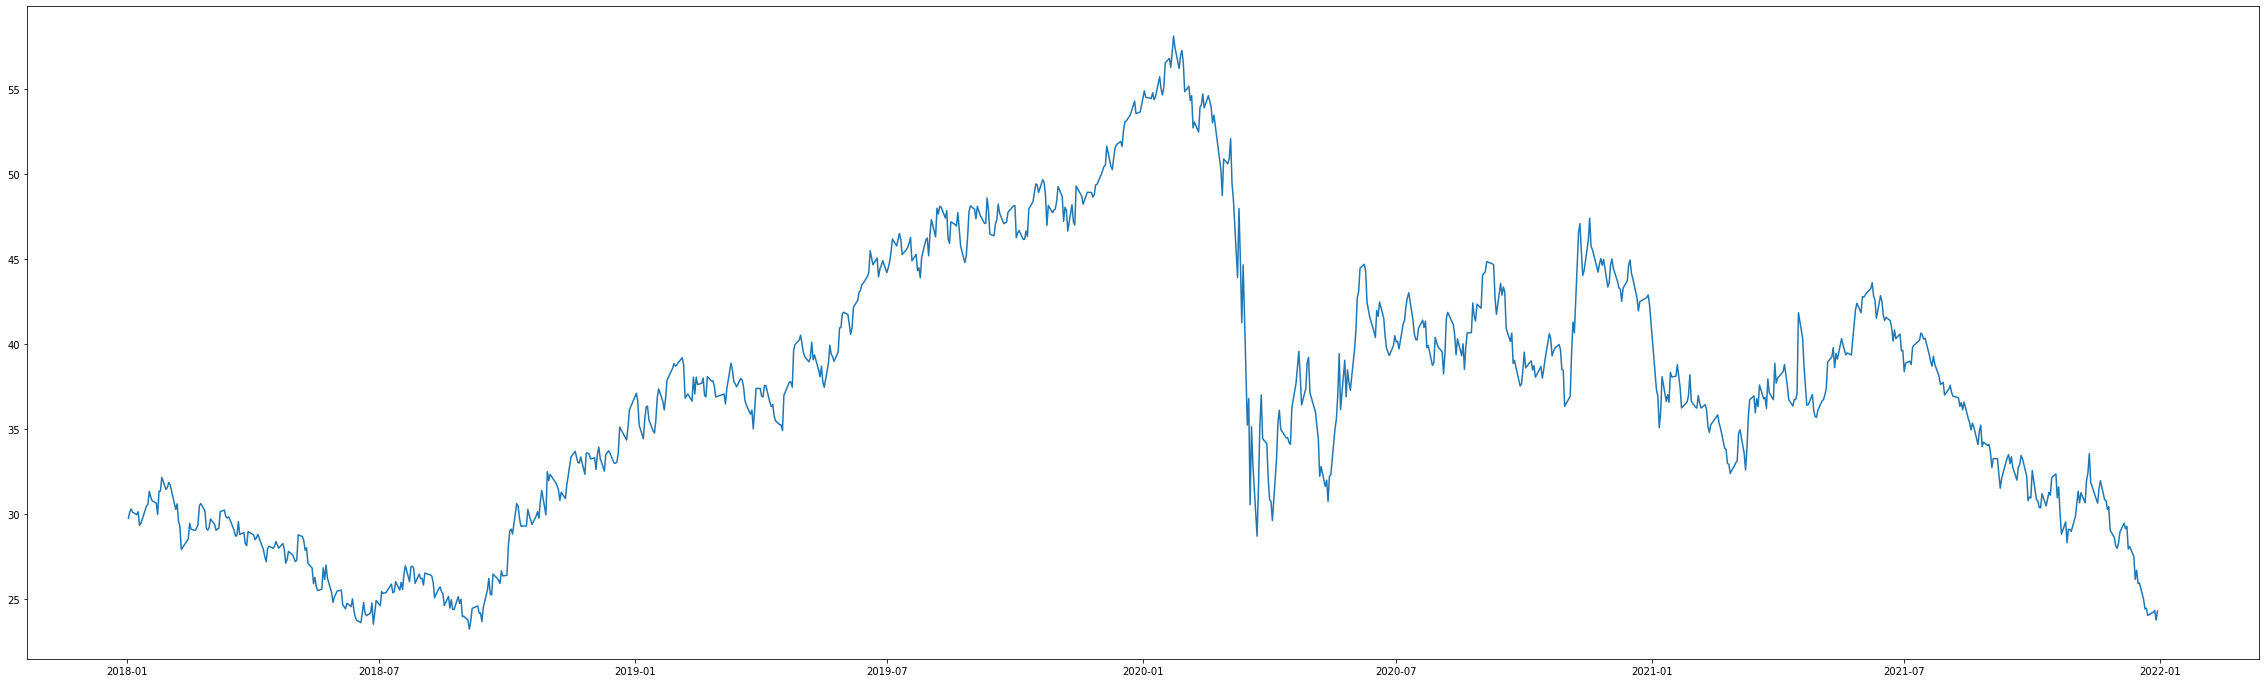

In [1633]:
plt.plot(pd.DataFrame(yf.download('LREN3.SA', start = '2018-01-01', end = '2021-12-31')['Adj Close']))

In [1634]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12912 entries, 0 to 1775
Data columns (total 28 columns):
 #   Column                                                          Non-Null Count  Dtype         
---  ------                                                          --------------  -----         
 0   Data                                                            12912 non-null  object        
 1    LiqCor  consolid:sim*                                          12912 non-null  float64       
 2    LiqSec  consolid:sim*                                          12912 non-null  float64       
 3    Exig / PL  consolid:sim*                                       12912 non-null  float64       
 4    DivBr/Ebitda  de 3 meses  consolid:sim*                        12912 non-null  float64       
 5    Margem Liquida  de 3 meses  consolid:sim*                      12912 non-null  float64       
 6   ROA de 3 meses                                                  12912 non-null  float64

In [1635]:
df_indicators2 = df_indicators.copy()

In [1636]:
df_indicators = df_indicators.groupby(['Código ajustado','Indice'],dropna=False).mean().reset_index()

In [1637]:
df_indicators.groupby(['Indice']).count()

,Código ajustado,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,Valor Mercado da empresa Em US Dollars em milhares,...,EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*,P/FCF Em US Dollars de 3 meses consolid:sim*,Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov,TIR média trimestral em 3 meses Em moeda orig,Bollinger 90/2 Média Em moeda orig,Volatilidade base trimestral 3 meses Em moeda orig,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Sharpe Ratio,Beta
Indice,,,,,,,,,,,,,,,,,,,,,
Ibov,73,73,73,73,73,73,73,73,73,73,...,73,73,73,73,73,73,73,73,73,73
S&P500,465,465,465,465,465,465,465,465,465,465,...,465,465,465,465,465,465,465,465,465,465


In [1638]:
df_indicators2.columns

Index(['Data', ' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig',
       ' Data do Bal  consolid:sim*', 'Códig

##Models Applications

##UMAP testing

In [1639]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1640]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10

In [1641]:
import umap

In [1642]:
indicators_application = df_indicators.drop(['Indice','Código ajustado','Valor Mercado da empresa Em US Dollars em milhares',' Patrim Liq  Em US Dollars  em milhares  consolid:sim*'],axis='columns').replace('-',0).astype(float)
indicators_application = indicators_application.fillna(0)

In [1643]:
indicators_application = indicators_application.fillna(0)

In [1644]:
columns = [' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig',
       'Sharpe Ratio', 'Beta']
indicators_data = indicators_application[columns].values
scaled_indicators_data = StandardScaler().fit_transform(indicators_data)

In [1645]:
indicators_data.shape

(538, 20)

In [1646]:
reducer = umap.UMAP()

In [1647]:
embedding = reducer.fit_transform(indicators_data)
embedding.shape 

(538, 2)

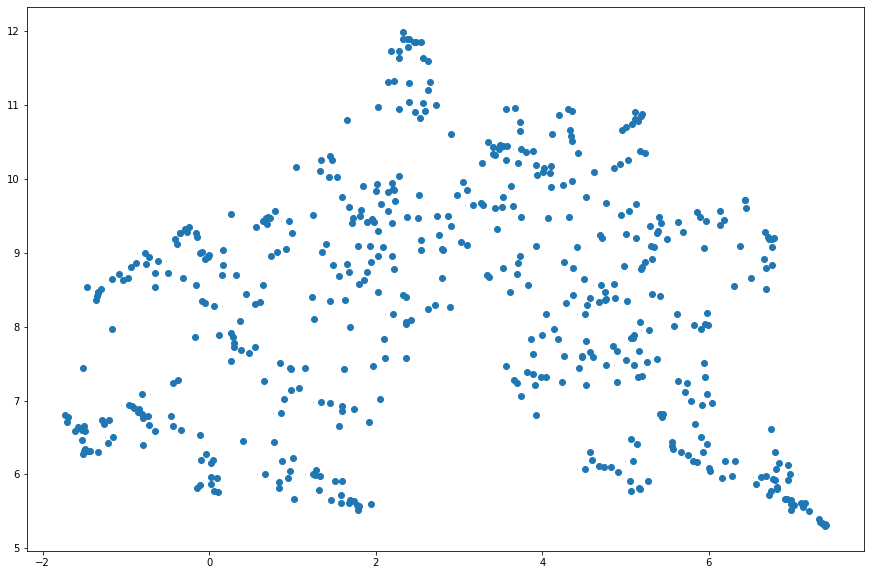

In [1648]:
plt.scatter(embedding[:,0], embedding[:,1])

Text(0.5, 1.0, 'UMAP projection of the S&P500 and Ibov Index')

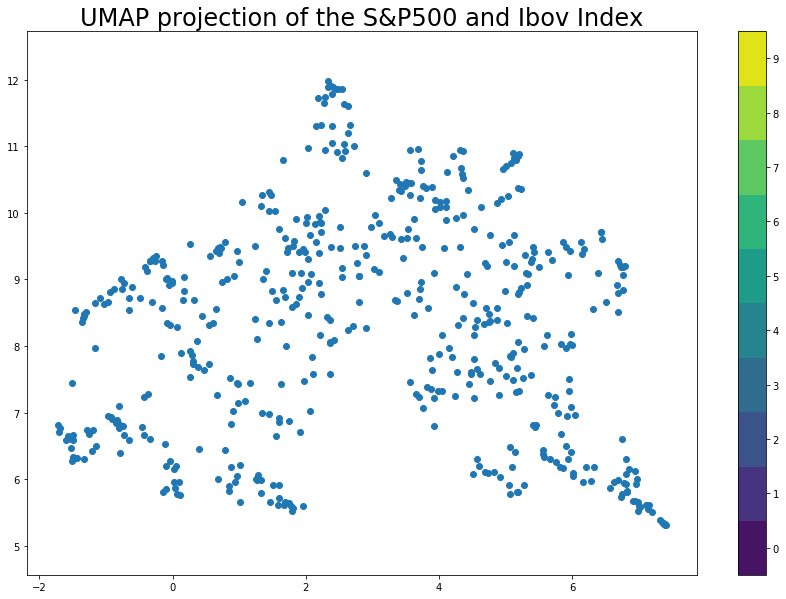

In [1649]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    #c=indicators_data
    )
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the S&P500 and Ibov Index', fontsize=24)

In [1650]:
data = indicators_data 

In [1651]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   range(len(u)), 
                   #c=data
                   )
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   u[:,1], 
                   #c=data
                   )
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], 
                   u[:,1], 
                   u[:,2], 
                   #c=data
                   )
    plt.title(title, fontsize=18)

In [1652]:
#for n in (2, 5, 10, 20, 50, 100, 200,300,400,500):
#    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [1653]:
#for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
#    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

In [1654]:
#draw_umap(n_components=3,n_neighbors=15, title='n_components = 3, n_neighbors = 200')

##K-Means application for UMAP output

In [1655]:
kmeans_input = pd.DataFrame(embedding)
kmeans_input.rename(columns={0:'x',1:'y'},inplace=True)

In [1656]:
columns = ['x','y']
#Normalização dos dados
for column in columns:
  kmeans_input[column] = (kmeans_input[column]-min(kmeans_input[column].dropna()))/(max(kmeans_input[column].dropna())-min(kmeans_input[column].dropna()))

In [1657]:
X = kmeans_input.iloc[:,[0,1]].values

In [1658]:
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from math import sqrt

In [1659]:
WCSS = []

In [1660]:
for i in range (1,11):
  kmeans = KMeans(n_clusters=i,random_state=0)
  kmeans.fit(X)
  WCSS.append(kmeans.inertia_)

Text(0, 0.5, 'wcss')

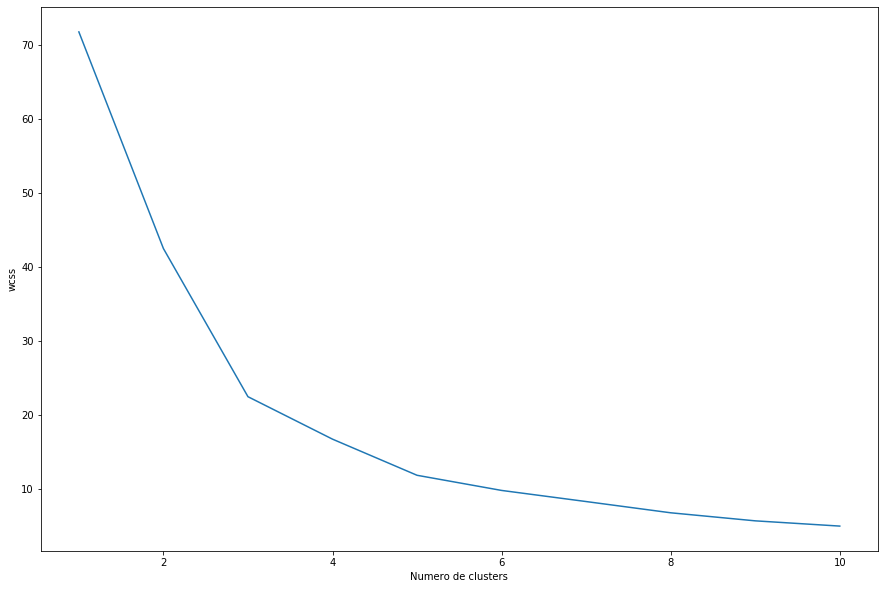

In [1661]:
plt.plot(range(1,11),WCSS)
plt.xlabel('Numero de clusters')
plt.ylabel('wcss')

In [1662]:
cluster_num = 4

In [1663]:
kmeans = KMeans(n_clusters=cluster_num, random_state=0)
previsoes = kmeans.fit_predict(X)

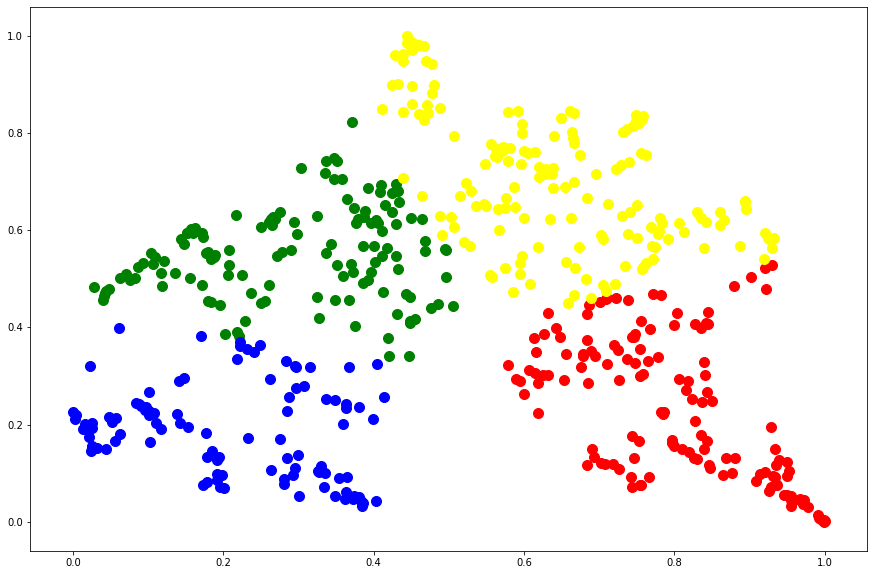

In [1664]:
plt.scatter(X[previsoes == 0,0], X[previsoes == 0,1],s=100, c='red', label = 'Cluster 1')
plt.scatter(X[previsoes == 1,0], X[previsoes == 1,1],s=100, c='green', label = 'Cluster 2')
plt.scatter(X[previsoes == 2,0], X[previsoes == 2,1],s=100, c='blue', label = 'Cluster 3')
plt.scatter(X[previsoes == 3,0], X[previsoes == 3,1],s=100, c='yellow', label = 'Cluster 4')
plt.scatter(X[previsoes == 4,0], X[previsoes == 4,1],s=100, c='orange', label = 'Cluster 5')

In [1665]:
kmeans_output = pd.DataFrame(np.column_stack((kmeans_input, previsoes)))

In [1666]:
kmeans_output

,0,1,2
0,0.502971,0.627896,3.0
1,0.089981,0.239002,2.0
2,0.589846,0.294567,0.0
3,0.895033,0.643470,3.0
4,0.806492,0.615342,3.0
...,...,...,...
533,0.705054,0.487834,3.0
534,0.667199,0.466732,3.0
535,0.117562,0.512080,1.0
536,0.187626,0.544459,1.0


In [1667]:
kmeans_output = kmeans_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [1668]:
#preenchendo a coluna de clusters no dataframe principal
indicators_application['Cluster UMAP K-Means'] = ''
for i in range(0,len(indicators_application)):
  cluster = int(kmeans_output['Cluster'].iloc[i])
  indicators_application['Cluster UMAP K-Means'].iloc[i] = int(cluster)

In [1669]:
kmeans_output.groupby('Cluster',dropna=False).count()

,x,y
Cluster,,
0.0,139,139
1.0,135,135
2.0,104,104
3.0,160,160


##UMAP n-neighbors x WCSS K-means

In [1670]:
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [1671]:
#função que plota o gráfico do WCSS pra cada n_neighbors do UMAP e adiciona os resultados numa matriz
def umap_kmeans(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);

    #k-means
    kmeans_input = pd.DataFrame(u)
    kmeans_input.rename(columns={0:'x',1:'y'},inplace=True)

    columns = ['x','y']
    for column in columns:
      kmeans_input[column] = (kmeans_input[column]-min(kmeans_input[column].dropna()))/(max(kmeans_input[column].dropna())-min(kmeans_input[column].dropna()))

    X = kmeans_input.iloc[:,[0,1]].values

    WCSS = []
    for i in range (1,11):
      kmeans = KMeans(n_clusters=i,random_state=0)
      kmeans.fit(X)
      WCSS.append(kmeans.inertia_)

    rel_umap_kmeans[0].append(n_neighbors)
    rel_umap_kmeans[1].append(optimal_number_of_clusters(WCSS))

    plt.plot(range(1,11),WCSS)
    plt.xlabel('Numero de clusters')
    plt.ylabel('wcss')

In [1672]:
rel_umap_kmeans = [[],[]]

#for n in range(2,200+1):
#    umap_kmeans(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [1673]:
#test = pd.DataFrame(rel_umap_kmeans).T
#test.rename(columns={0:'n_neighbors',1:'n_clusters'},inplace=True)

In [1674]:
#plt.plot(test['n_neighbors'],test['n_clusters'])
#plt.xlabel('n_neighbors')
#plt.ylabel('n_clusters')

##K-Means application for the same features used in UMAP

In [1675]:
indicators_data.shape

(538, 20)

In [1676]:
X = indicators_data#.iloc[:,[0,13]].values

In [1677]:
X

array([[0.05586858, 0.04694659, 0.31054974, ..., 0.90667282, 0.03027307,
        0.39743447],
       [0.01167887, 0.01111436, 0.29381005, ..., 0.82184782, 0.03019146,
        0.45623483],
       [0.02754744, 0.00563185, 0.31066293, ..., 0.87610645, 0.03020241,
        0.34475956],
       ...,
       [0.01963447, 0.01271715, 0.31074835, ..., 0.8553596 , 0.03029406,
        0.44184633],
       [0.0277567 , 0.01393765, 0.31135549, ..., 0.88117984, 0.03024422,
        0.41934935],
       [0.07185687, 0.04837164, 0.31080374, ..., 0.91197692, 0.03028843,
        0.35250867]])

In [1678]:
WCSS = []

In [1679]:
for i in range (1,11):
  kmeans = KMeans(n_clusters=i,random_state=0)
  kmeans.fit(X)
  WCSS.append(kmeans.inertia_)

Text(0, 0.5, 'wcss')

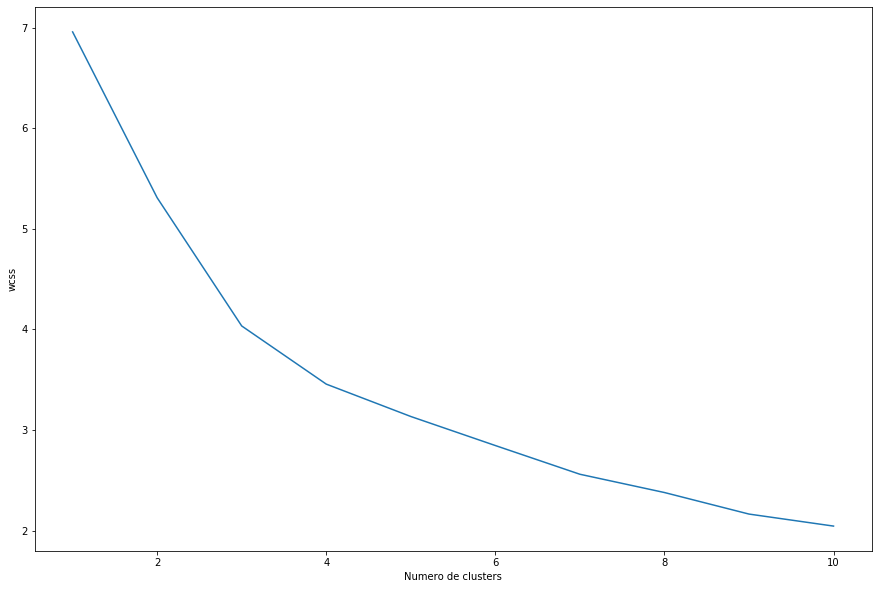

In [1680]:
plt.plot(range(1,11),WCSS)
plt.xlabel('Numero de clusters')
plt.ylabel('wcss')

In [1681]:
kmeans = KMeans(n_clusters=4, random_state=0)
previsoes = kmeans.fit_predict(X)

In [1682]:
kmeans_output = pd.DataFrame(np.column_stack((kmeans_input, previsoes)))

In [1683]:
kmeans_output = kmeans_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [1684]:
indicators_application['Cluster k-means'] = ''
for i in range(0,len(indicators_application)):
  cluster = int(kmeans_output['Cluster'].iloc[i])
  indicators_application['Cluster k-means'].iloc[i] = int(cluster)

In [1685]:
kmeans_output.groupby('Cluster',dropna=False).count()

,x,y
Cluster,,
0.0,261,261
1.0,194,194
2.0,5,5
3.0,78,78


In [1686]:
indicators_application.columns

Index([' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl', 'Price/Book ratio',
       'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig', 'Sharpe Ratio',
       'Beta', 'Cluster UMAP K-Means', 'Cluster k-means'],
      dtype='object')

##PAM

In [1687]:
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1688]:
# — — — — — — -Importing Packages — — — — — — — — — — — -
from sklearn_extra.cluster import KMedoids

In [1689]:
X = kmeans_input.iloc[:,[0,1]].values

In [1690]:
kmedoids = KMedoids(n_clusters=cluster_num, random_state=0).fit(X)

In [1691]:
import random

In [1692]:
kmeans_input

,x,y
0,0.502971,0.627896
1,0.089981,0.239002
2,0.589846,0.294567
3,0.895033,0.643470
4,0.806492,0.615342
...,...,...
533,0.705054,0.487834
534,0.667199,0.466732
535,0.117562,0.512080
536,0.187626,0.544459


In [1693]:
kmedoids.predict([X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))]])

array([0, 1, 1])

In [1694]:
kmedoids.cluster_centers_

array([[0.3770822 , 0.6142759 ],
       [0.8391138 , 0.1485278 ],
       [0.17670843, 0.18345043],
       [0.7378388 , 0.5918766 ]], dtype=float32)

Text(0.5, 1.0, 'KMedoids clustering. Medoids are represented in cyan.')

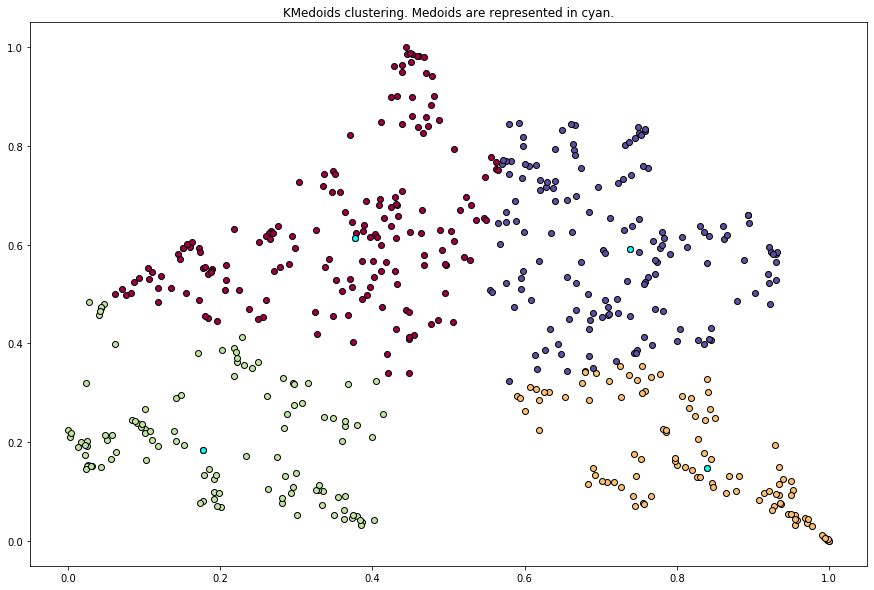

In [1695]:
labels = kmedoids.labels_

unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = X[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    kmedoids.cluster_centers_[:, 0],
    kmedoids.cluster_centers_[:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering. Medoids are represented in cyan.")

In [1696]:
indicators_application['Cluster PAM'] = ''
for i in range(0,len(indicators_application)):
  cluster = int(kmedoids.labels_[i])
  indicators_application['Cluster PAM'].iloc[i] = int(cluster)

##Hierarquical

In [1697]:
Y = kmeans_input
Y

,x,y
0,0.502971,0.627896
1,0.089981,0.239002
2,0.589846,0.294567
3,0.895033,0.643470
4,0.806492,0.615342
...,...,...
533,0.705054,0.487834
534,0.667199,0.466732
535,0.117562,0.512080
536,0.187626,0.544459


<Figure size 21600x21600 with 0 Axes>

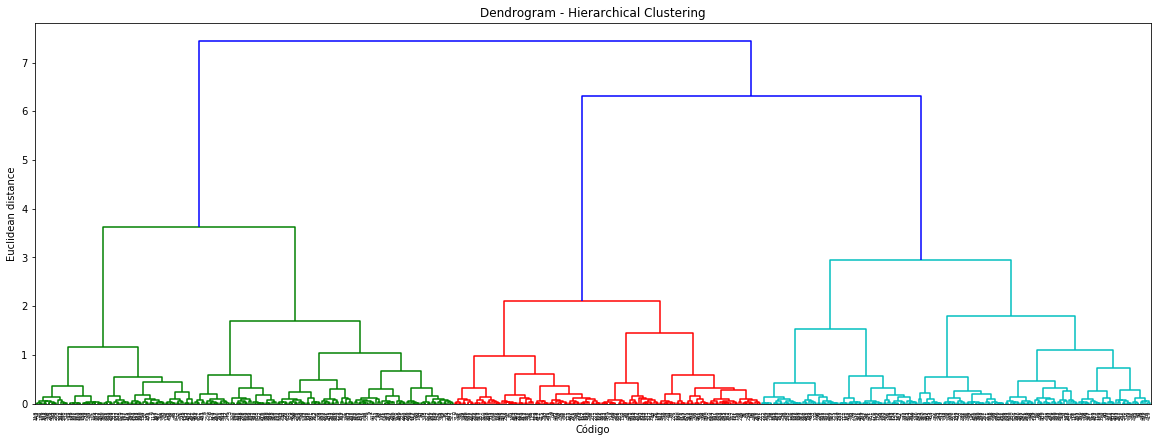

<Figure size 21600x21600 with 0 Axes>

In [1698]:
import scipy.cluster.hierarchy as sc

# Plot dendrogram
plt.figure(figsize=(20, 7))  
plt.title("Dendrograms")  

# Create dendrogram
sc.dendrogram(sc.linkage(Y, method='ward'))

plt.title('Dendrogram - Hierarchical Clustering')
plt.xlabel('Código')
plt.ylabel('Euclidean distance')
plt.figure(figsize = (300, 300))

In [1699]:
from sklearn.cluster import AgglomerativeClustering

In [1700]:
cluster_hierarquical = AgglomerativeClustering(n_clusters=cluster_num, affinity='euclidean', linkage='ward')
hierarquical = cluster_hierarquical.fit(Y)

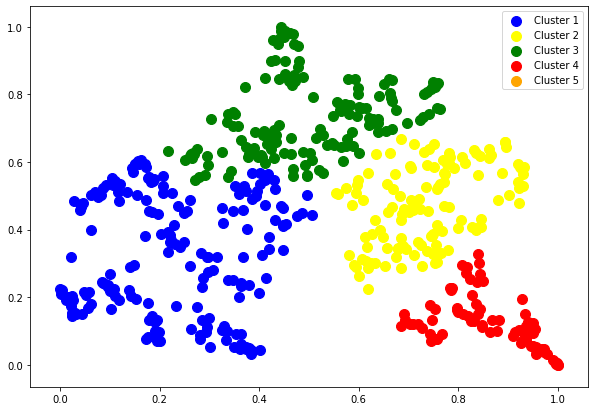

In [1701]:
indicators = Y.values

plt.figure(figsize=(10, 7))
plt.scatter(indicators[hierarquical.labels_ == 0, 0], indicators[hierarquical.labels_ == 0, 1], s = 100, c = 'blue', label = 'Cluster 1')
plt.scatter(indicators[hierarquical.labels_ == 1, 0], indicators[hierarquical.labels_ == 1, 1], s = 100, c = 'yellow', label = 'Cluster 2')
plt.scatter(indicators[hierarquical.labels_ == 2, 0], indicators[hierarquical.labels_ == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(indicators[hierarquical.labels_ == 3, 0], indicators[hierarquical.labels_ == 3, 1], s = 100, c = 'red', label = 'Cluster 4')
plt.scatter(indicators[hierarquical.labels_ == 4, 0], indicators[hierarquical.labels_ == 4, 1], s = 100, c = 'orange', label = 'Cluster 5')
plt.legend()
plt.show()

In [1702]:
hierarquical_output = pd.DataFrame(np.column_stack((kmeans_input, hierarquical.labels_)))

In [1703]:
hierarquical_output = hierarquical_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [1704]:
indicators_application['Cluster Hierarquical'] = ''
for i in range(0,len(indicators_application)):
  cluster = int(hierarquical_output['Cluster'].iloc[i])
  indicators_application['Cluster Hierarquical'].iloc[i] = int(cluster)

## Consolidação

In [1705]:
df_indicators.columns

Index(['Código ajustado', 'Indice', ' LiqCor  consolid:sim*',
       ' LiqSec  consolid:sim*', ' Exig / PL  consolid:sim*',
       ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Valor Mercado da empresa Em US Dollars em milhares',
       ' Patrim Liq  Em US Dollars  em milhares  consolid:sim*',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig', 'Sharpe Ratio',


In [1706]:
len(indicators_application) - len(df_indicators)

0

In [1707]:
indicators_application.columns

Index([' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl', 'Price/Book ratio',
       'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig', 'Sharpe Ratio',
       'Beta', 'Cluster UMAP K-Means', 'Cluster k-means', 'Cluster PAM',
       'Cluster Hierarquical'],
      dtype='object')

In [1708]:
df_indicators['Cluster UMAP K-Means'] = ''
df_indicators['Cluster k-means'] = ''
df_indicators['Cluster PAM'] = ''
df_indicators['Cluster Hierarquical'] = ''

In [1709]:
models = ['Cluster UMAP K-Means','Cluster k-means','Cluster PAM','Cluster Hierarquical'] 
for model in models:
  df_indicators[model] = ''
  for i in range(0,len(indicators_application)):
    cluster = int(indicators_application[model].iloc[i])
    df_indicators[model].iloc[i] = int(cluster)

In [1710]:
df_indicators

,Código ajustado,Indice,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,...,Bollinger 90/2 Média Em moeda orig,Volatilidade base trimestral 3 meses Em moeda orig,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Sharpe Ratio,Beta,Cluster UMAP K-Means,Cluster k-means,Cluster PAM,Cluster Hierarquical
0,A,S&P500,0.055869,0.046947,0.310550,0.117198,0.917721,0.554865,0.328195,0.032411,...,0.014314,0.072304,0.064957,0.906673,0.030273,0.397434,3,0,0,2
1,AAL,S&P500,0.011679,0.011114,0.293810,0.117209,0.917259,0.528572,0.361141,0.032373,...,0.006059,0.147551,0.134395,0.821848,0.030191,0.456235,2,3,2,0
2,AAP,S&P500,0.027547,0.005632,0.310663,0.117199,0.917610,0.547220,0.328209,0.032399,...,0.028503,0.095917,0.086187,0.876106,0.030202,0.344760,0,0,1,1
3,AAPL,S&P500,0.025580,0.025956,0.310726,0.117197,0.917933,0.585746,0.332227,0.032381,...,0.011196,0.082145,0.074081,0.914477,0.030304,0.410687,3,0,3,1
4,ABBV,S&P500,0.026537,0.025087,0.310779,0.117201,0.917877,0.555553,0.339209,0.032392,...,0.014273,0.076265,0.068463,0.900580,0.030253,0.352042,3,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,YUM,S&P500,0.022740,0.023732,0.310297,0.117205,0.917920,0.606310,0.381855,0.032394,...,0.016089,0.061332,0.055652,0.922641,0.030268,0.329187,3,1,3,1
534,ZBH,S&P500,0.038185,0.020369,0.310574,0.117205,0.917606,0.536333,0.327389,0.032373,...,0.023020,0.079988,0.072189,0.926534,0.030220,0.361339,3,0,3,1
535,ZBRA,S&P500,0.019634,0.012717,0.310748,0.117202,0.917622,0.551170,0.328281,0.032429,...,0.041604,0.111354,0.100705,0.855360,0.030294,0.441846,1,0,0,0
536,ZION,S&P500,0.027757,0.013938,0.311355,0.117206,0.917390,0.533257,0.327760,0.032381,...,0.007745,0.100259,0.090691,0.881180,0.030244,0.419349,1,0,0,0


In [1711]:
#df_indicators.loc['Cluster UMAP K-Means'] = indicators_application['Cluster UMAP K-Means'].astype(float)
#df_indicators.loc['Cluster k-means'] = indicators_application['Cluster k-means'].astype(float)
#df_indicators.loc['Cluster PAM'] = indicators_application['Cluster PAM'].astype(float)
#df_indicators.loc['Cluster Hierarquical'] = indicators_application['Cluster Hierarquical'].astype(float)

In [1712]:
df_indicators_dtref = df_indicators.copy()

In [1713]:
df_indicators_dtref[['Cluster UMAP K-Means', 'Cluster k-means', 'Cluster PAM','Cluster Hierarquical']] = df_indicators_dtref[['Cluster UMAP K-Means', 'Cluster k-means', 'Cluster PAM','Cluster Hierarquical']].astype(int)

In [1714]:
df_indicators_dtref

,Código ajustado,Indice,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,...,Bollinger 90/2 Média Em moeda orig,Volatilidade base trimestral 3 meses Em moeda orig,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Sharpe Ratio,Beta,Cluster UMAP K-Means,Cluster k-means,Cluster PAM,Cluster Hierarquical
0,A,S&P500,0.055869,0.046947,0.310550,0.117198,0.917721,0.554865,0.328195,0.032411,...,0.014314,0.072304,0.064957,0.906673,0.030273,0.397434,3,0,0,2
1,AAL,S&P500,0.011679,0.011114,0.293810,0.117209,0.917259,0.528572,0.361141,0.032373,...,0.006059,0.147551,0.134395,0.821848,0.030191,0.456235,2,3,2,0
2,AAP,S&P500,0.027547,0.005632,0.310663,0.117199,0.917610,0.547220,0.328209,0.032399,...,0.028503,0.095917,0.086187,0.876106,0.030202,0.344760,0,0,1,1
3,AAPL,S&P500,0.025580,0.025956,0.310726,0.117197,0.917933,0.585746,0.332227,0.032381,...,0.011196,0.082145,0.074081,0.914477,0.030304,0.410687,3,0,3,1
4,ABBV,S&P500,0.026537,0.025087,0.310779,0.117201,0.917877,0.555553,0.339209,0.032392,...,0.014273,0.076265,0.068463,0.900580,0.030253,0.352042,3,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,YUM,S&P500,0.022740,0.023732,0.310297,0.117205,0.917920,0.606310,0.381855,0.032394,...,0.016089,0.061332,0.055652,0.922641,0.030268,0.329187,3,1,3,1
534,ZBH,S&P500,0.038185,0.020369,0.310574,0.117205,0.917606,0.536333,0.327389,0.032373,...,0.023020,0.079988,0.072189,0.926534,0.030220,0.361339,3,0,3,1
535,ZBRA,S&P500,0.019634,0.012717,0.310748,0.117202,0.917622,0.551170,0.328281,0.032429,...,0.041604,0.111354,0.100705,0.855360,0.030294,0.441846,1,0,0,0
536,ZION,S&P500,0.027757,0.013938,0.311355,0.117206,0.917390,0.533257,0.327760,0.032381,...,0.007745,0.100259,0.090691,0.881180,0.030244,0.419349,1,0,0,0


# Ts Features

##Reading data

In [336]:
df_ibov_features = pd.read_excel('/content/drive/MyDrive/IC ITA/df_Features_Ibov.xlsx')
df_ibov_features['Indice'] = 'Ibov'

df_sp500_features = pd.read_excel('/content/drive/MyDrive/IC ITA/df_Features_SP500.xlsx').rename(columns={'unique_id':'Código'})
df_sp500_features['Indice'] = 'S&P500'

df_indicators_features = pd.concat([df_sp500_features,df_ibov_features]).drop('Unnamed: 0',axis='columns')

In [337]:
df_indicators_features

,Código,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,crossing_points,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1,Indice
0,A,0.409325,23,-28.048995,0.086791,1.490140e-08,1.489508e-08,2.260365e-13,0.000523,1,...,15,1,-0.367334,0.783027,-0.631981,1.194119,-0.729109,1.503309,-0.233997,S&P500
1,AAL,0.444551,23,-18.305093,0.043385,1.490224e-08,1.489431e-08,1.421007e-12,0.010302,1,...,8,1,0.101278,1.272607,-0.217840,0.646837,-0.495520,0.652494,0.037392,S&P500
2,AAP,0.456325,23,-27.906333,0.143533,1.490116e-08,2.910258e-10,0.000000e+00,0.005369,1,...,16,1,-0.434876,0.929963,-0.605135,1.124590,-0.669117,1.210058,-0.333618,S&P500
3,AAPL,0.379082,23,-26.430065,0.158570,1.490272e-08,2.875035e-10,1.639721e-12,0.000258,1,...,16,1,-0.279101,0.555910,-0.440556,0.937416,-0.570956,1.277200,-0.240945,S&P500
4,ABBV,0.376635,23,-26.615092,0.110332,1.490116e-08,1.489613e-08,0.000000e+00,0.007156,1,...,15,1,-0.414487,1.540309,-0.558107,1.857736,-0.597467,1.853404,-0.348933,S&P500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,VALE3,0.334208,23,-33.611740,0.321794,1.490116e-08,2.825846e-10,0.000000e+00,0.004601,1,...,15,1,-0.347456,0.261871,-0.535398,0.723522,-0.658143,1.196353,-0.163097,Ibov
70,VIIA3,0.376266,23,-27.809848,0.107609,1.490168e-08,2.915011e-10,5.650508e-13,0.002836,1,...,16,1,-0.430207,0.927184,-0.596678,1.274089,-0.644703,1.409231,-0.326718,Ibov
71,VIVT3,0.490203,23,-7.253861,0.327952,7.595821e-01,7.595821e-01,0.000000e+00,0.007792,1,...,13,1,0.110174,0.064405,-0.026276,0.088235,-0.429111,0.347862,0.044202,Ibov
72,WEGE3,0.380091,23,-23.865743,0.071488,1.490182e-08,2.904799e-10,6.772401e-13,0.004167,1,...,13,1,-0.220589,0.581730,-0.447667,0.831758,-0.612087,1.195074,-0.226041,Ibov


In [338]:
df_indicators_features.columns

Index(['Código', 'hurst', 'series_length', 'unitroot_pp', 'unitroot_kpss',
       'hw_alpha', 'hw_beta', 'hw_gamma', 'stability', 'nperiods',
       'seasonal_period', 'trend', 'spike', 'linearity', 'curvature', 'e_acf1',
       'e_acf10', 'seasonal_strength', 'peak', 'trough', 'x_pacf5',
       'diff1x_pacf5', 'diff2x_pacf5', 'seas_pacf', 'nonlinearity',
       'lumpiness', 'alpha', 'beta', 'arch_acf', 'garch_acf', 'arch_r2',
       'garch_r2', 'flat_spots', 'entropy', 'crossing_points', 'arch_lm',
       'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10', 'diff2_acf1',
       'diff2_acf10', 'seas_acf1', 'Indice'],
      dtype='object')

##EDA

In [339]:
df_indicators_features.isnull().sum()

Código               0
hurst                0
series_length        0
unitroot_pp          0
unitroot_kpss        0
hw_alpha             0
hw_beta              0
hw_gamma             0
stability            0
nperiods             0
seasonal_period      0
trend                0
spike                0
linearity            0
curvature            0
e_acf1               0
e_acf10              0
seasonal_strength    0
peak                 0
trough               0
x_pacf5              0
diff1x_pacf5         0
diff2x_pacf5         0
seas_pacf            0
nonlinearity         0
lumpiness            0
alpha                0
beta                 0
arch_acf             0
garch_acf            0
arch_r2              0
garch_r2             0
flat_spots           0
entropy              0
crossing_points      0
arch_lm              0
x_acf1               0
x_acf10              0
diff1_acf1           0
diff1_acf10          0
diff2_acf1           0
diff2_acf10          0
seas_acf1            0
Indice     

In [340]:
#Cria a coluna Código ajustado, que tem o ".SA" no final do ticker das ações brasileiras
df_indicators_features['Código ajustado']=df_indicators_features['Código']
df_indicators_features.loc[df_indicators_features['Indice']=='Ibov','Código ajustado'] = df_indicators_features.loc[df_indicators_features['Indice']=='Ibov','Código ajustado']+str('.SA')

In [341]:
df_indicators_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539 entries, 0 to 73
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Código             539 non-null    object 
 1   hurst              539 non-null    float64
 2   series_length      539 non-null    int64  
 3   unitroot_pp        539 non-null    float64
 4   unitroot_kpss      539 non-null    float64
 5   hw_alpha           539 non-null    float64
 6   hw_beta            539 non-null    float64
 7   hw_gamma           539 non-null    float64
 8   stability          539 non-null    float64
 9   nperiods           539 non-null    int64  
 10  seasonal_period    539 non-null    int64  
 11  trend              539 non-null    float64
 12  spike              539 non-null    float64
 13  linearity          539 non-null    float64
 14  curvature          539 non-null    float64
 15  e_acf1             539 non-null    float64
 16  e_acf10            539 non-

In [342]:
df_indicators_features.columns

Index(['Código', 'hurst', 'series_length', 'unitroot_pp', 'unitroot_kpss',
       'hw_alpha', 'hw_beta', 'hw_gamma', 'stability', 'nperiods',
       'seasonal_period', 'trend', 'spike', 'linearity', 'curvature', 'e_acf1',
       'e_acf10', 'seasonal_strength', 'peak', 'trough', 'x_pacf5',
       'diff1x_pacf5', 'diff2x_pacf5', 'seas_pacf', 'nonlinearity',
       'lumpiness', 'alpha', 'beta', 'arch_acf', 'garch_acf', 'arch_r2',
       'garch_r2', 'flat_spots', 'entropy', 'crossing_points', 'arch_lm',
       'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10', 'diff2_acf1',
       'diff2_acf10', 'seas_acf1', 'Indice', 'Código ajustado'],
      dtype='object')

In [343]:
#normaliza as colunas de formato float
columns = ['hurst', 'series_length', 'unitroot_pp',
       'unitroot_kpss', 'hw_alpha', 'hw_beta', 'hw_gamma', 'stability',
       'nperiods', 'seasonal_period', 'trend', 'spike', 'linearity',
       'curvature', 'e_acf1', 'e_acf10', 'seasonal_strength', 'peak', 'trough',
       'x_pacf5', 'diff1x_pacf5', 'diff2x_pacf5', 'seas_pacf', 'nonlinearity',
       'lumpiness', 'alpha', 'beta', 'arch_acf', 'garch_acf', 'arch_r2',
       'garch_r2', 'flat_spots', 'entropy', 'crossing_points', 'arch_lm',
       'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10', 'diff2_acf1',
       'diff2_acf10', 'seas_acf1']

for column in columns:
  #indicators_application[column] = indicators_application[column].loc[indicators_application[column].isnull()==False]
  #indicators_application = indicators_application[np.isfinite(indicators_application[column]) == True]
  df_indicators_features[column] = (df_indicators_features[column]-min(df_indicators_features[column].dropna())) /(max(df_indicators_features[column].dropna())-min(df_indicators_features[column].dropna()))

##Models Applications

##UMAP testing

In [344]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10

In [345]:
import umap

In [346]:
indicators_application_features = df_indicators_features.drop(['Código','Indice','Código ajustado'],axis='columns').replace('-',0).astype(float)
indicators_application_features = indicators_application_features.fillna(0)

In [347]:
indicators_application_features = indicators_application_features.fillna(0)

In [348]:
indicators_data_features = indicators_application_features[columns].values
scaled_indicators_data = StandardScaler().fit_transform(indicators_data_features)

In [349]:
indicators_data_features.shape

(539, 42)

In [350]:
reducer = umap.UMAP()

In [351]:
embedding = reducer.fit_transform(indicators_data_features)
embedding.shape 

(539, 2)

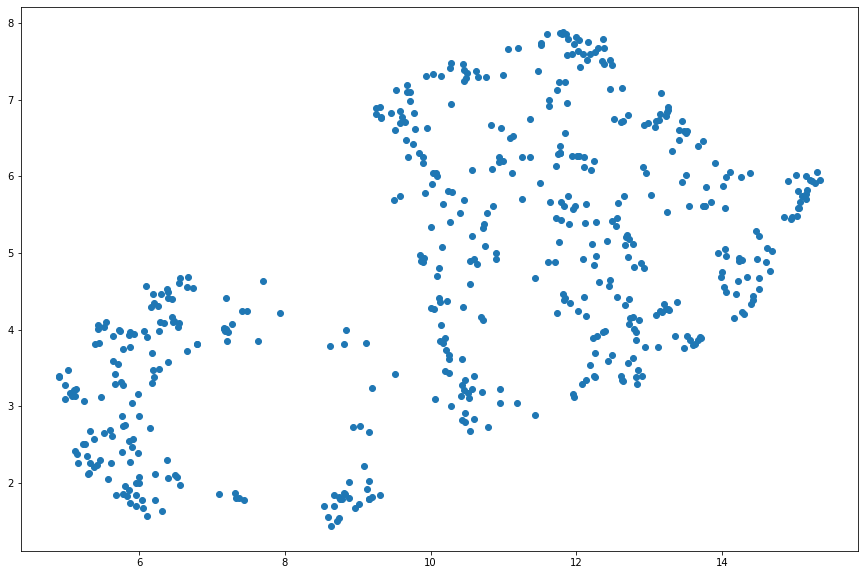

In [352]:
plt.scatter(embedding[:,0], embedding[:,1])

Text(0.5, 1.0, 'UMAP projection of the S&P500 and Ibov Index')

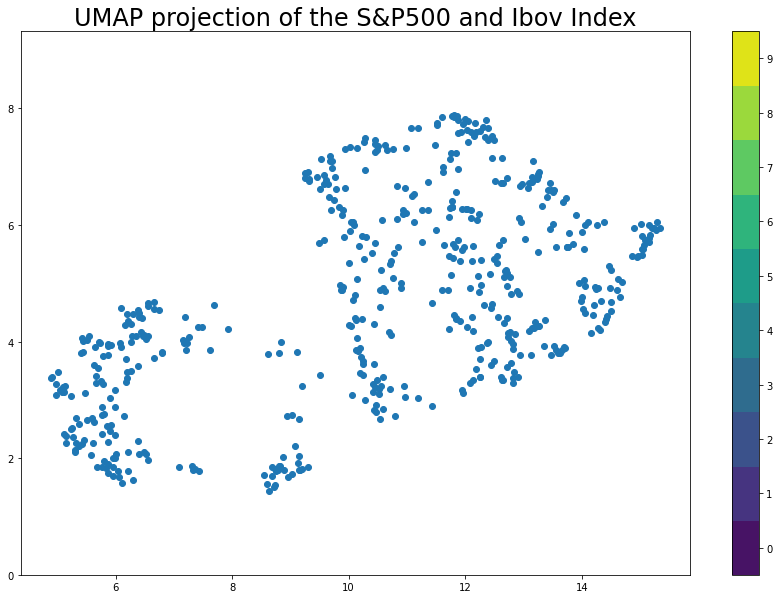

In [353]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    #c=indicators_data
    )
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the S&P500 and Ibov Index', fontsize=24)

In [354]:
data = indicators_data_features 

In [355]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   range(len(u)), 
                   #c=data
                   )
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], 
                   u[:,1], 
                   #c=data
                   )
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], 
                   u[:,1], 
                   u[:,2], 
                   #c=data
                   )
    plt.title(title, fontsize=18)

In [356]:
#for n in (2, 5, 10, 20, 50, 100, 200,300,400,500):
#    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [357]:
#for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
#    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

In [358]:
len(indicators_data_features)

539

In [359]:
#draw_umap(n_components=3,n_neighbors=200, title='n_components = 3, n_neighbors = 200')

##K-Means application for UMAP output

In [360]:
kmeans_input = pd.DataFrame(embedding)
kmeans_input.rename(columns={0:'x',1:'y'},inplace=True)

In [361]:
columns = ['x','y']
#Normalização dos dados
for column in columns:
  kmeans_input[column] = (kmeans_input[column]-min(kmeans_input[column].dropna()))/(max(kmeans_input[column].dropna())-min(kmeans_input[column].dropna()))

In [362]:
X = kmeans_input.iloc[:,[0,1]].values

In [363]:
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,10
from pandas.plotting import register_matplotlib_converters

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from math import sqrt

In [364]:
WCSS = []

In [365]:
for i in range (1,11):
  kmeans = KMeans(n_clusters=i,random_state=0)
  kmeans.fit(X)
  WCSS.append(kmeans.inertia_)

Text(0, 0.5, 'wcss')

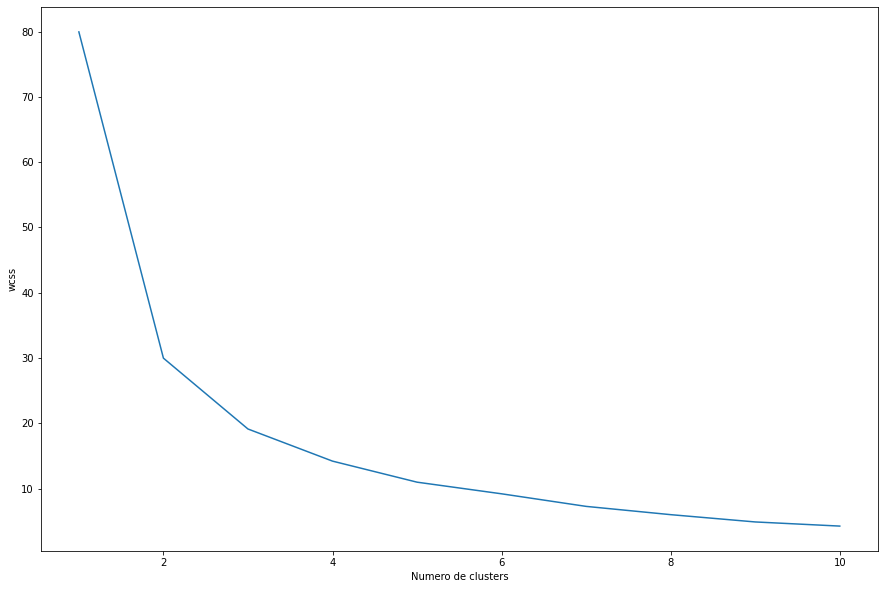

In [366]:
plt.plot(range(1,11),WCSS)
plt.xlabel('Numero de clusters')
plt.ylabel('wcss')

In [367]:
kmeans = KMeans(n_clusters=4, random_state=0)
previsoes = kmeans.fit_predict(X)

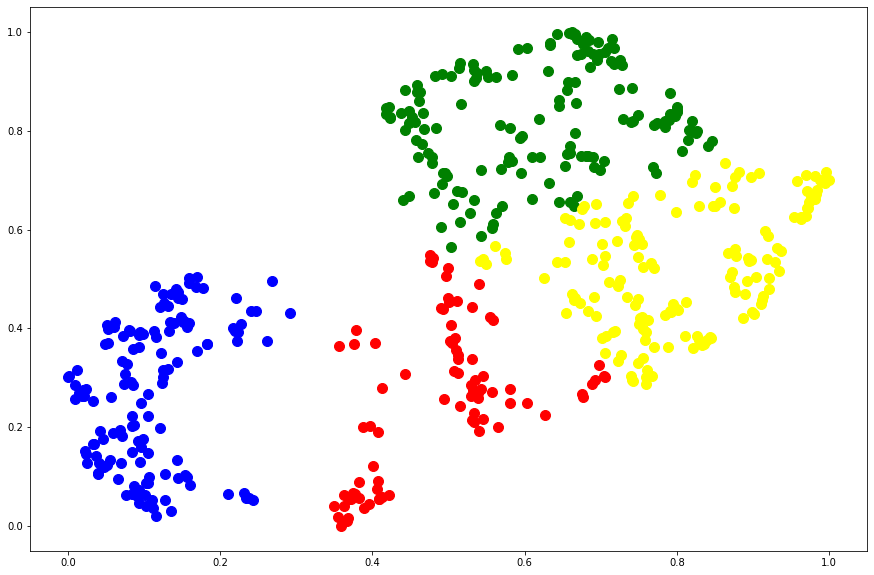

In [368]:
plt.scatter(X[previsoes == 0,0], X[previsoes == 0,1],s=100, c='red', label = 'Cluster 1')
plt.scatter(X[previsoes == 1,0], X[previsoes == 1,1],s=100, c='green', label = 'Cluster 2')
plt.scatter(X[previsoes == 2,0], X[previsoes == 2,1],s=100, c='blue', label = 'Cluster 3')
plt.scatter(X[previsoes == 3,0], X[previsoes == 3,1],s=100, c='yellow', label = 'Cluster 4')
plt.scatter(X[previsoes == 4,0], X[previsoes == 4,1],s=100, c='orange', label = 'Cluster 5')

In [369]:
kmeans_output = pd.DataFrame(np.column_stack((kmeans_input, previsoes)))

In [370]:
kmeans_output

,0,1,2
0,0.080722,0.394381,2.0
1,0.515086,0.242791,0.0
2,0.182006,0.368946,2.0
3,0.819909,0.695829,3.0
4,0.570777,0.648646,1.0
...,...,...,...
534,0.374473,0.066509,0.0
535,0.826440,0.800232,1.0
536,0.365852,0.009872,0.0
537,0.126758,0.104927,2.0


In [371]:
kmeans_output = kmeans_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [372]:
#preenchendo a coluna de clusters no dataframe principal
indicators_application_features['Cluster UMAP K-Means'] = ''
for i in range(0,len(indicators_application_features)):
  cluster = int(kmeans_output['Cluster'].iloc[i])
  indicators_application_features['Cluster UMAP K-Means'].iloc[i] = int(cluster)

In [373]:
kmeans_output.groupby('Cluster',dropna=False).count()

,x,y
Cluster,,
0.0,85,85
1.0,157,157
2.0,139,139
3.0,158,158


##PAM

In [374]:
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [375]:
# — — — — — — -Importing Packages — — — — — — — — — — — -
from sklearn_extra.cluster import KMedoids

In [376]:
X = kmeans_input.iloc[:,[0,1]].values

In [377]:
kmedoids = KMedoids(n_clusters=4, random_state=0).fit(X)

In [378]:
import random

In [379]:
kmeans_input

,x,y
0,0.080722,0.394381
1,0.515086,0.242791
2,0.182006,0.368946
3,0.819909,0.695829
4,0.570777,0.648646
...,...,...
534,0.374473,0.066509
535,0.826440,0.800232
536,0.365852,0.009872
537,0.126758,0.104927


In [380]:
kmedoids.predict([X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))]])

array([3, 1, 1])

In [381]:
kmedoids.cluster_centers_

array([[0.7510946 , 0.42025954],
       [0.6593353 , 0.7700526 ],
       [0.12675768, 0.10492703],
       [0.1321824 , 0.39542547]], dtype=float32)

Text(0.5, 1.0, 'KMedoids clustering. Medoids are represented in cyan.')

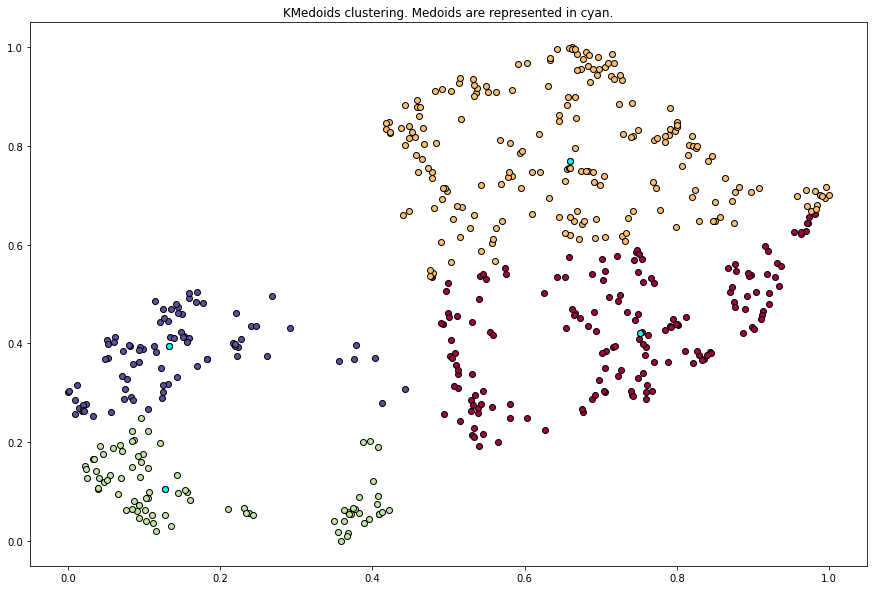

In [382]:
labels = kmedoids.labels_

unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = X[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    kmedoids.cluster_centers_[:, 0],
    kmedoids.cluster_centers_[:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering. Medoids are represented in cyan.")

In [383]:
indicators_application_features['Cluster PAM'] = ''
for i in range(0,len(indicators_application_features)):
  cluster = int(kmedoids.labels_[i])
  indicators_application_features['Cluster PAM'].iloc[i] = int(cluster)

##Hierarquical

In [384]:
Y = kmeans_input
Y

,x,y
0,0.080722,0.394381
1,0.515086,0.242791
2,0.182006,0.368946
3,0.819909,0.695829
4,0.570777,0.648646
...,...,...
534,0.374473,0.066509
535,0.826440,0.800232
536,0.365852,0.009872
537,0.126758,0.104927


<Figure size 21600x21600 with 0 Axes>

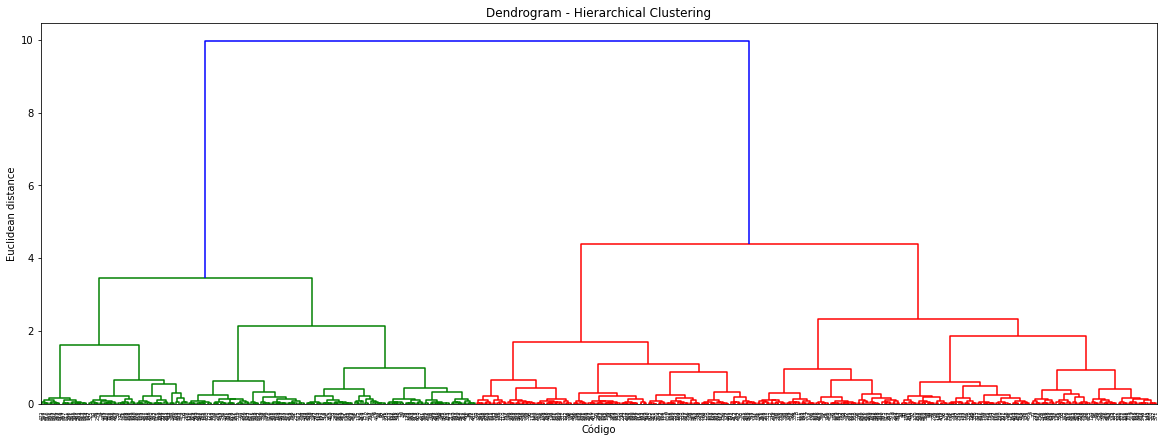

<Figure size 21600x21600 with 0 Axes>

In [385]:
import scipy.cluster.hierarchy as sc

# Plot dendrogram
plt.figure(figsize=(20, 7))  
plt.title("Dendrograms")  

# Create dendrogram
sc.dendrogram(sc.linkage(Y, method='ward'))

plt.title('Dendrogram - Hierarchical Clustering')
plt.xlabel('Código')
plt.ylabel('Euclidean distance')
plt.figure(figsize = (300, 300))

In [386]:
from sklearn.cluster import AgglomerativeClustering

In [387]:
cluster_hierarquical = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
hierarquical = cluster_hierarquical.fit(Y)

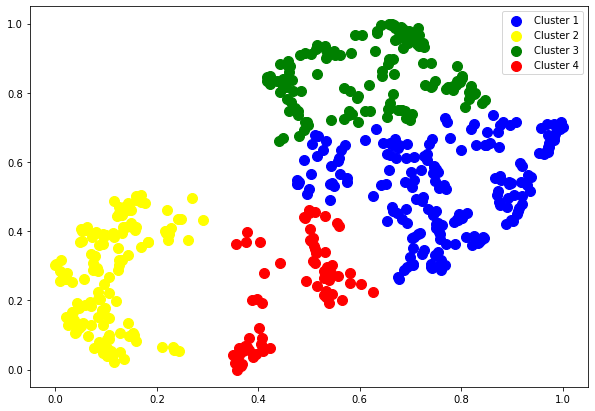

In [388]:
indicators = Y.values

plt.figure(figsize=(10, 7))
plt.scatter(indicators[hierarquical.labels_ == 0, 0], indicators[hierarquical.labels_ == 0, 1], s = 100, c = 'blue', label = 'Cluster 1')
plt.scatter(indicators[hierarquical.labels_ == 1, 0], indicators[hierarquical.labels_ == 1, 1], s = 100, c = 'yellow', label = 'Cluster 2')
plt.scatter(indicators[hierarquical.labels_ == 2, 0], indicators[hierarquical.labels_ == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(indicators[hierarquical.labels_ == 3, 0], indicators[hierarquical.labels_ == 3, 1], s = 100, c = 'red', label = 'Cluster 4')
plt.legend()
plt.show()

In [389]:
hierarquical_output = pd.DataFrame(np.column_stack((kmeans_input, hierarquical.labels_)))

In [390]:
hierarquical_output = hierarquical_output.rename(columns={0:'x',1:'y',2:'Cluster'})

In [391]:
indicators_application_features['Cluster Hierarquical'] = ''
for i in range(0,len(indicators_application_features)):
  cluster = int(hierarquical_output['Cluster'].iloc[i])
  indicators_application_features['Cluster Hierarquical'].iloc[i] = int(cluster)

## Consolidação

In [392]:
df_indicators_features.columns

Index(['Código', 'hurst', 'series_length', 'unitroot_pp', 'unitroot_kpss',
       'hw_alpha', 'hw_beta', 'hw_gamma', 'stability', 'nperiods',
       'seasonal_period', 'trend', 'spike', 'linearity', 'curvature', 'e_acf1',
       'e_acf10', 'seasonal_strength', 'peak', 'trough', 'x_pacf5',
       'diff1x_pacf5', 'diff2x_pacf5', 'seas_pacf', 'nonlinearity',
       'lumpiness', 'alpha', 'beta', 'arch_acf', 'garch_acf', 'arch_r2',
       'garch_r2', 'flat_spots', 'entropy', 'crossing_points', 'arch_lm',
       'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10', 'diff2_acf1',
       'diff2_acf10', 'seas_acf1', 'Indice', 'Código ajustado'],
      dtype='object')

In [393]:
len(indicators_application_features) - len(df_indicators_features)

0

In [394]:
df_indicators_features['Cluster UMAP K-Means'] = indicators_application_features['Cluster UMAP K-Means'].astype(float)
df_indicators_features['Cluster PAM'] = indicators_application_features['Cluster PAM'].astype(float)
df_indicators_features['Cluster Hierarquical'] = indicators_application_features['Cluster Hierarquical'].astype(float)

In [395]:
df_indicators_features

,Código,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1,Indice,Código ajustado,Cluster UMAP K-Means,Cluster PAM,Cluster Hierarquical
0,A,0.774800,NaN,0.300999,0.259242,1.865980e-08,1.865189e-08,0.033430,0.007192,NaN,...,0.227620,0.313367,0.218110,0.328394,0.449998,S&P500,A,2.0,3.0,1.0
1,AAL,0.841478,NaN,0.543824,0.129590,1.866086e-08,1.865092e-08,0.210160,0.141644,NaN,...,0.596333,0.169746,0.466520,0.142536,0.777134,S&P500,AAL,0.0,0.0,3.0
2,AAP,0.863766,NaN,0.304554,0.428728,1.865950e-08,3.644278e-10,0.000000,0.073828,NaN,...,0.251521,0.295120,0.281908,0.264334,0.329914,S&P500,AAP,2.0,3.0,1.0
3,AAPL,0.717553,NaN,0.341343,0.473644,1.866145e-08,3.600171e-10,0.242507,0.003550,NaN,...,0.398048,0.246001,0.386299,0.279001,0.441623,S&P500,AAPL,3.0,1.0,0.0
4,ABBV,0.712921,NaN,0.336732,0.329560,1.865950e-08,1.865320e-08,0.000000,0.098391,NaN,...,0.293391,0.487516,0.358105,0.404872,0.311452,S&P500,ABBV,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,VALE3,0.632613,NaN,0.162371,0.961189,1.865950e-08,3.538576e-10,0.000000,0.063268,NaN,...,0.313608,0.189870,0.293579,0.261340,0.535462,Ibov,VALE3.SA,0.0,2.0,3.0
70,VIIA3,0.712224,NaN,0.306958,0.321426,1.866016e-08,3.650230e-10,0.083568,0.038999,NaN,...,0.259050,0.334353,0.307872,0.307843,0.338231,Ibov,VIIA3.SA,1.0,1.0,2.0
71,VIVT3,0.927891,NaN,0.819228,0.979584,9.511625e-01,9.511625e-01,0.000000,0.107137,NaN,...,0.766885,0.023155,0.537143,0.075990,0.785343,Ibov,VIVT3.SA,0.0,2.0,3.0
72,WEGE3,0.719464,NaN,0.405248,0.213533,1.866033e-08,3.637442e-10,0.100161,0.057300,NaN,...,0.391717,0.218274,0.342557,0.261061,0.459589,Ibov,WEGE3.SA,2.0,2.0,1.0


In [396]:
df_indicators_features = pd.merge(df_indicators_features,df_indicators_dtref[['Código ajustado','Sharpe Ratio']],how='inner',on='Código ajustado')

In [397]:
df_indicators2 = df_indicators.copy()
df_indicators2 = df_indicators2.rename(columns={'Código ajustado':'Código'})
df_indicators2

,Código,Indice,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,...,Bollinger 90/2 Média Em moeda orig,Volatilidade base trimestral 3 meses Em moeda orig,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Sharpe Ratio,Beta,Cluster UMAP K-Means,Cluster k-means,Cluster PAM,Cluster Hierarquical
0,A,S&P500,0.039062,0.032837,0.310550,0.117198,0.917721,0.548755,0.328195,0.032411,...,0.014314,0.072304,0.064957,0.906673,0.030273,0.397434,3,1,2,1
1,AAL,S&P500,0.008165,0.007774,0.293810,0.117209,0.917259,0.522751,0.361141,0.032373,...,0.006059,0.147551,0.134395,0.821848,0.030191,0.456235,2,3,3,2
2,AAP,S&P500,0.019260,0.003939,0.310663,0.117199,0.917610,0.541194,0.328209,0.032399,...,0.028503,0.095917,0.086187,0.876106,0.030202,0.344760,1,0,0,0
3,AAPL,S&P500,0.017885,0.018155,0.310726,0.117197,0.917933,0.579296,0.332227,0.032381,...,0.011196,0.082145,0.074081,0.914477,0.030304,0.410687,0,1,2,3
4,ABBV,S&P500,0.018554,0.017547,0.310779,0.117201,0.917877,0.549435,0.339209,0.032392,...,0.014273,0.076265,0.068463,0.900580,0.030253,0.352042,0,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,YUM,S&P500,0.015899,0.016599,0.310297,0.117205,0.917920,0.599633,0.381855,0.032394,...,0.016089,0.061332,0.055652,0.922641,0.030268,0.329187,0,0,2,0
535,ZBH,S&P500,0.026698,0.014247,0.310574,0.117205,0.917606,0.530427,0.327389,0.032373,...,0.023020,0.079988,0.072189,0.926534,0.030220,0.361339,0,0,2,0
536,ZBRA,S&P500,0.013728,0.008895,0.310748,0.117202,0.917622,0.545100,0.328281,0.032429,...,0.041604,0.111354,0.100705,0.855360,0.030294,0.441846,3,1,1,1
537,ZION,S&P500,0.019407,0.009749,0.311355,0.117206,0.917390,0.527385,0.327760,0.032381,...,0.007745,0.100259,0.090691,0.881180,0.030244,0.419349,3,1,1,1


In [398]:
assets_select_features = df_indicators_features.head(0)
for model in ('Cluster UMAP K-Means','Cluster PAM',	'Cluster Hierarquical'):
  for i in range(0,4):
    assets_select_i_features = df_indicators_features.loc[df_indicators_features[model].astype(int)==int(i)].sort_values(by='Sharpe Ratio',ascending=False)[:5]
    assets_select_i_features['Modelo'] = str(model)
    assets_select_features = assets_select_features.append([assets_select_i_features])

In [399]:
assets_select_features

,Código,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,diff2_acf1,diff2_acf10,seas_acf1,Indice,Código ajustado,Cluster UMAP K-Means,Cluster PAM,Cluster Hierarquical,Sharpe Ratio,Modelo
513,MRFG3,0.739215,NaN,0.309528,0.663553,1.866196e-08,1.864711e-08,0.353414,0.091814,NaN,...,0.298247,0.232864,0.406748,Ibov,MRFG3.SA,0.0,2.0,3.0,0.107206,Cluster UMAP K-Means
494,EMBR3,0.674102,NaN,0.395383,0.147284,1.865958e-08,1.865114e-08,0.009352,0.026632,NaN,...,0.280154,0.171752,0.559615,Ibov,EMBR3.SA,0.0,0.0,3.0,0.050496,Cluster UMAP K-Means
473,BEEF3,0.654441,NaN,0.288762,0.252306,1.866152e-08,3.650987e-10,0.242718,0.738126,NaN,...,0.356930,0.338221,0.291415,Ibov,BEEF3.SA,0.0,3.0,3.0,0.040166,Cluster UMAP K-Means
483,CPFE3,0.552720,NaN,0.281747,0.898176,1.866095e-08,3.488226e-10,0.163537,0.431170,NaN,...,0.224179,0.193898,0.588987,Ibov,CPFE3.SA,0.0,2.0,3.0,0.036472,Cluster UMAP K-Means
527,SBSP3,0.734979,NaN,0.379537,0.727361,1.865950e-08,3.520482e-10,0.000000,0.692648,NaN,...,0.313694,0.227655,0.401831,Ibov,SBSP3.SA,0.0,2.0,3.0,0.035509,Cluster UMAP K-Means
521,PRIO3,0.822511,NaN,0.347632,0.189708,1.866065e-08,3.649744e-10,0.141511,0.022736,NaN,...,0.204826,0.414487,0.539866,Ibov,PRIO3.SA,1.0,1.0,2.0,0.057163,Cluster UMAP K-Means
103,CRL,0.699342,NaN,0.313455,0.165603,1.866094e-08,3.661325e-10,0.176551,0.007497,NaN,...,0.249751,0.293124,0.396853,S&P500,CRL,1.0,1.0,2.0,0.030788,Cluster UMAP K-Means
286,MPWR,0.774390,NaN,0.361695,0.241691,1.865950e-08,3.650531e-10,0.000000,0.009603,NaN,...,0.282256,0.273670,0.492851,S&P500,MPWR,1.0,1.0,2.0,0.030699,Cluster UMAP K-Means
201,HOLX,0.796993,NaN,0.299426,0.333798,1.865988e-08,3.606973e-10,0.044909,0.087486,NaN,...,0.136290,0.472398,0.522752,S&P500,HOLX,1.0,1.0,0.0,0.030524,Cluster UMAP K-Means
356,PWR,0.542425,NaN,0.240805,0.284049,1.865953e-08,1.865131e-08,0.002979,0.023238,NaN,...,0.160203,0.455621,0.324458,S&P500,PWR,1.0,1.0,2.0,0.030480,Cluster UMAP K-Means


In [400]:
assets_select2 = df_indicators2.head(0)

for model in ('Cluster UMAP K-Means','Cluster PAM',	'Cluster Hierarquical'):
  for i in range(0,cluster_num):
    assets_select_i_2 = df_indicators2.loc[df_indicators2[model].astype(int)==int(i)].sort_values(by='Sharpe Ratio',ascending=False)[:5]
    assets_select_i_2['Modelo'] = str(model)
    assets_select2 = assets_select2.append([assets_select_i_2])

  assets_select2 = assets_select2[['Código','Sharpe Ratio']].drop_duplicates()
  assets_select2 = assets_select2.reset_index()[['Código','Sharpe Ratio']]
assets_select2

,Código,Sharpe Ratio
0,ITSA4.SA,0.035543
1,BBSE3.SA,0.030755
2,CPRT,0.030347
3,WST,0.030329
4,MSCI,0.030324
5,IGTI11.SA,0.050035
6,RADL3.SA,0.040263
7,ENGI11.SA,0.038513
8,EQTL3.SA,0.037628
9,TAEE11.SA,0.036490


# Analysis

-------------------------------------------------------------------------------
##Método de seleção 3: Seleção dos ativos com maior Obj. em cada cluster a cada Trimestre
------------------------------------------------------------------------------

---
Equação de seleção do cluster ótimo:

\begin{equation}
\ Obj \ = max(\frac{Liq. Corrente + Liq. Seca + Margem Líq. + ROA + ROE + TIR + Sharpe}{(\frac{Dívida}{EBITDA}\ + \frac{P}{L}\ + \frac{EV}{EBITDA}\ + \frac{P}{FCF}\ + Volatilidade + Variância + Máx. Drawdoun + \frac{Exigível}{PL}\ + \frac{Price}{Book Ratio}\ + Beta})\
\end{equation}

In [1715]:
def compare_quarter(quarter_0,n_assets):

  quarters = ['1T2016','2T2016','3T2016','4T2016','1T2017','2T2017','3T2017','4T2017','1T2018','2T2018','3T2018','4T2018','1T2019','2T2019','3T2019','4T2019','1T2020','2T2020','3T2020','4T2020','1T2021','2T2021','3T2021']

  #Gerando a função objetivo
  df_indicators2['max'] = df_indicators2[' LiqCor  consolid:sim*']+df_indicators2[' LiqSec  consolid:sim*']+df_indicators2[' Margem Liquida  de 3 meses  consolid:sim*']+df_indicators2['ROA de 3 meses']+df_indicators2['ROE de 3 meses']+df_indicators2['TIR média trimestral em 3 meses Em moeda orig']+df_indicators2['Sharpe Ratio']
  df_indicators2['min'] = df_indicators2[' DivBr/Ebitda  de 3 meses  consolid:sim*']+df_indicators2['P/L de 3 meses ajust pela infl']+df_indicators2['EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*']+df_indicators2['P/FCF Em US Dollars de 3 meses consolid:sim*']+df_indicators2['Volatilidade base trimestral 3 meses Em moeda orig']+df_indicators2['VAR % base diária confiança: 95% 3 meses Em moeda orig']+df_indicators2['Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig']+df_indicators2[' Exig / PL  consolid:sim*']+df_indicators2['Price/Book ratio']+df_indicators2['Beta']
  df_indicators2['Cluster_select'] = df_indicators2['max']/df_indicators2['min']
  df_indicators2['Cluster_select'] = (df_indicators2['Cluster_select']-min(df_indicators2['Cluster_select'].dropna()))/(max(df_indicators2['Cluster_select'].dropna())-min(df_indicators2['Cluster_select'].dropna()))

  #Umap
  indicators_application = df_indicators2.loc[df_indicators2['Data'].astype(str) == quarter_0]
  indicators_application = indicators_application#.drop(['Indice','Código ajustado','Valor Mercado da empresa Em US Dollars em milhares',' Patrim Liq  Em US Dollars  em milhares  consolid:sim*'],axis=1)
  indicators_application = indicators_application.fillna(0)

  columns = [' LiqCor  consolid:sim*', ' LiqSec  consolid:sim*',
       ' Exig / PL  consolid:sim*', ' DivBr/Ebitda  de 3 meses  consolid:sim*',
       ' Margem Liquida  de 3 meses  consolid:sim*', 'ROA de 3 meses',
       'ROE de 3 meses', 'P/L de 3 meses ajust pela infl',
       'Price/Book ratio', 'EV Em US Dollars em milhares consolid:sim*',
       'EV/EBITDA emp Em US Dollars de 3 meses consolid:sim*',
       'P/FCF Em US Dollars de 3 meses consolid:sim*',
       'Media do fechamento em 1 trimestre Em US Dollars ajust p/ prov',
       'TIR média trimestral em 3 meses Em moeda orig',
       'Bollinger 90/2 Média Em moeda orig',
       'Volatilidade base trimestral 3 meses Em moeda orig',
       'VAR % base diária confiança: 95% 3 meses Em moeda orig',
       'Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig',
       'Sharpe Ratio', 'Beta']

  indicators_data = indicators_application[columns].values
  scaled_indicators_data = StandardScaler().fit_transform(indicators_data)

  reducer = umap.UMAP()
  embedding = reducer.fit_transform(indicators_data)

  #K-Means
  kmeans_input = pd.DataFrame(embedding)
  kmeans_input.rename(columns={0:'x',1:'y'},inplace=True)

  columns = ['x','y']

  #Normalização dos dados
  for column in columns:
    kmeans_input[column] = (kmeans_input[column]-min(kmeans_input[column].dropna()))/(max(kmeans_input[column].dropna())-min(kmeans_input[column].dropna()))

    X = kmeans_input.iloc[:,[0,1]].values

    kmeans = KMeans(n_clusters=4, random_state=0)
    previsoes = kmeans.fit_predict(X)
    
    kmeans_output = pd.DataFrame(np.column_stack((kmeans_input, previsoes)))
    kmeans_output = kmeans_output.rename(columns={0:'x',1:'y',2:'Cluster'})

  #Preenchendo a coluna de clusters no dataframe principal
  indicators_application['Cluster UMAP K-Means'] = ''

  for i in range(0,len(indicators_application)):
    cluster = int(kmeans_output['Cluster'].iloc[i])
    indicators_application['Cluster UMAP K-Means'].iloc[i] = int(cluster)

  #PAM
  X = kmeans_input.iloc[:,[0,1]].values
  kmedoids = KMedoids(n_clusters=cluster_num, random_state=0).fit(X)
  kmedoids.predict([X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))]])
  
  #Preenchendo a coluna de clusters no dataframe principal
  indicators_application['Cluster PAM'] = ''

  for i in range(0,len(indicators_application)):
    cluster = int(kmedoids.labels_[i])
    indicators_application['Cluster PAM'].iloc[i] = int(cluster)

  #Hierarchical
  Y = kmeans_input
  cluster_hierarquical = AgglomerativeClustering(n_clusters=cluster_num, affinity='euclidean', linkage='ward')
  hierarquical = cluster_hierarquical.fit(Y)

  hierarquical_output = pd.DataFrame(np.column_stack((Y, hierarquical.labels_)))
  hierarquical_output = hierarquical_output.rename(columns={0:'x',1:'y',2:'Cluster'})

  #Preenchendo a coluna de clusters no dataframe principal
  indicators_application['Cluster Hierarquical'] = ''

  for i in range(0,len(indicators_application)):
    cluster = int(hierarquical_output['Cluster'].iloc[i])
    indicators_application['Cluster Hierarquical'].iloc[i] = int(cluster)

  df_indicators_dtref = indicators_application


  #Selecionando os n ativos de maior Sharpe de cada Cluster
  assets_select = df_indicators_dtref.head(0)
  for model in ('Cluster UMAP K-Means','Cluster PAM',	'Cluster Hierarquical'):
    for i in range(0,cluster_num):
      assets_select_i = df_indicators_dtref.loc[df_indicators_dtref[model].astype(int)==int(i)].sort_values(by='Cluster_select',ascending=False)[:n_assets]
      assets_select_i['Modelo'] = str(model)
      assets_select = assets_select.append([assets_select_i])

    assets_select = assets_select[['Código','Setor NAICS','Sharpe Ratio','Cluster_select']].drop_duplicates()
    assets_select = assets_select.reset_index()[['Código','Setor NAICS','Sharpe Ratio','Cluster_select']]

  return assets_select

### Importante (Rodar)

In [1618]:
df_indicators3 = df_indicators2.copy()
df_indicators3

,Data,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,Valor Mercado da empresa Em US Dollars em milhares,...,Volatilidade base trimestral 3 meses Em moeda orig,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Data do Bal consolid:sim*,Código,Setor NAICS,Indice,Sharpe Ratio,Beta,Código ajustado
0,1T2016,0.021684,0.020206,0.310850,0.117197,0.916479,0.538222,0.327971,0.032399,0.004471,...,0.079748,0.071858,0.993366,2016-01-31,A,Indústria manufatureira,S&P500,0.030128,0.374808,A
1,2T2016,0.064395,0.054923,0.310530,0.117200,0.917661,0.544745,0.327697,0.032432,0.004945,...,0.073117,0.065867,0.852164,2016-04-30,A,Indústria manufatureira,S&P500,0.030259,0.457635,A
2,3T2016,0.064140,0.055064,0.310524,0.117199,0.917722,0.549804,0.327891,0.032410,0.005231,...,0.066505,0.059484,0.817443,2016-07-31,A,Indústria manufatureira,S&P500,0.030454,0.414810,A
3,4T2016,0.081246,0.070125,0.310530,0.117198,0.917711,0.549947,0.327925,0.032408,0.005020,...,0.067334,0.059856,0.958113,2016-10-31,A,Indústria manufatureira,S&P500,0.030015,0.469993,A
4,1T2017,0.070086,0.060253,0.310529,0.117198,0.917803,0.556318,0.328198,0.032396,0.005837,...,0.065070,0.058862,0.843399,2017-01-31,A,Indústria manufatureira,S&P500,0.030385,0.429557,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,4T2020,0.013638,0.033869,0.310516,0.117759,0.917607,0.633321,0.331239,0.032372,0.003896,...,0.073243,0.065835,0.933087,2020-12-31,BBSE3,Serviços financeiros e seguros,Ibov,0.013058,0.316212,BBSE3.SA
1772,1T2021,0.052215,0.053492,0.310654,0.118267,0.917559,0.535630,0.327447,0.032451,0.000473,...,0.134377,0.120780,0.901215,2021-03-31,YDUQ3,Educacão,Ibov,0.020092,0.382822,YDUQ3.SA
1773,2T2021,0.030982,0.032287,0.310653,0.118137,0.917684,0.544953,0.328100,0.032385,0.000668,...,0.139024,0.127712,0.709405,2021-06-30,YDUQ3,Educacão,Ibov,0.058251,0.447734,YDUQ3.SA
1774,3T2021,0.023300,0.024616,0.310655,0.118117,0.917613,0.539131,0.327694,0.032394,0.000440,...,0.129702,0.117172,1.000000,2021-09-30,YDUQ3,Educacão,Ibov,0.016893,0.403383,YDUQ3.SA


### Preliminar Test

In [1619]:
df_indicators2 = df_indicators2.rename(columns={'Código ajustado':'Código'})
# df_indicators2['Código'] = df_indicators2['Código'].str.replace('.SA','')
df_indicators2

,Data,LiqCor consolid:sim*,LiqSec consolid:sim*,Exig / PL consolid:sim*,DivBr/Ebitda de 3 meses consolid:sim*,Margem Liquida de 3 meses consolid:sim*,ROA de 3 meses,ROE de 3 meses,P/L de 3 meses ajust pela infl,Valor Mercado da empresa Em US Dollars em milhares,...,Volatilidade base trimestral 3 meses Em moeda orig,VAR % base diária confiança: 95% 3 meses Em moeda orig,Max Drd (c/rec) ajust p/ prov 3 meses Em moeda orig,Data do Bal consolid:sim*,Código,Setor NAICS,Indice,Sharpe Ratio,Beta,Código
0,1T2016,0.021684,0.020206,0.310850,0.117197,0.916479,0.538222,0.327971,0.032399,0.004471,...,0.079748,0.071858,0.993366,2016-01-31,A,Indústria manufatureira,S&P500,0.030128,0.374808,A
1,2T2016,0.064395,0.054923,0.310530,0.117200,0.917661,0.544745,0.327697,0.032432,0.004945,...,0.073117,0.065867,0.852164,2016-04-30,A,Indústria manufatureira,S&P500,0.030259,0.457635,A
2,3T2016,0.064140,0.055064,0.310524,0.117199,0.917722,0.549804,0.327891,0.032410,0.005231,...,0.066505,0.059484,0.817443,2016-07-31,A,Indústria manufatureira,S&P500,0.030454,0.414810,A
3,4T2016,0.081246,0.070125,0.310530,0.117198,0.917711,0.549947,0.327925,0.032408,0.005020,...,0.067334,0.059856,0.958113,2016-10-31,A,Indústria manufatureira,S&P500,0.030015,0.469993,A
4,1T2017,0.070086,0.060253,0.310529,0.117198,0.917803,0.556318,0.328198,0.032396,0.005837,...,0.065070,0.058862,0.843399,2017-01-31,A,Indústria manufatureira,S&P500,0.030385,0.429557,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,4T2020,0.013638,0.033869,0.310516,0.117759,0.917607,0.633321,0.331239,0.032372,0.003896,...,0.073243,0.065835,0.933087,2020-12-31,BBSE3,Serviços financeiros e seguros,Ibov,0.013058,0.316212,BBSE3.SA
1772,1T2021,0.052215,0.053492,0.310654,0.118267,0.917559,0.535630,0.327447,0.032451,0.000473,...,0.134377,0.120780,0.901215,2021-03-31,YDUQ3,Educacão,Ibov,0.020092,0.382822,YDUQ3.SA
1773,2T2021,0.030982,0.032287,0.310653,0.118137,0.917684,0.544953,0.328100,0.032385,0.000668,...,0.139024,0.127712,0.709405,2021-06-30,YDUQ3,Educacão,Ibov,0.058251,0.447734,YDUQ3.SA
1774,3T2021,0.023300,0.024616,0.310655,0.118117,0.917613,0.539131,0.327694,0.032394,0.000440,...,0.129702,0.117172,1.000000,2021-09-30,YDUQ3,Educacão,Ibov,0.016893,0.403383,YDUQ3.SA


### Rodando a Função

In [1620]:
import warnings
warnings.filterwarnings('ignore')

## Para 3 ativos de cada Cluster de acordo com o critério de maior Obj.

In [1716]:
quarters = ['1T2016','2T2016','3T2016','4T2016','1T2017','2T2017','3T2017','4T2017','1T2018','2T2018','3T2018','4T2018','1T2019','2T2019','3T2019','4T2019','1T2020','2T2020','3T2020','4T2020','1T2021','2T2021','3T2021']

#DataFrame Final
df_final = pd.DataFrame()

#Criar um DataFrame vazio
cesta_final = pd.DataFrame(columns=['Código','Setor NAICS','Sharpe Ratio','Cluster_select','Quarter'])

#loop para percorrer cada trimestre
for quarter in quarters:

    #função para pegar a cesta do trimestre
    cesta = compare_quarter(quarter,10)

    #Criar uma cesta temporária
    cesta_temp = pd.DataFrame(columns=['Código','Setor NAICS','Sharpe Ratio','Cluster_select'])

    #Fazer um merge entre a cesta_final e a df_indicators2 para atualizar a func.obj da cesta final
    df_indicators_dtref = df_indicators3.loc[df_indicators3['Data'].astype(str) == quarter]

    cesta_final =  cesta_final.merge(df_indicators_dtref, how='inner', on = 'Código').rename(columns={'Sharpe Ratio_y':'Sharpe Ratio','Setor NAICS_x':'Setor NAICS'})
    cesta_final = cesta_final[['Código','Setor NAICS','Sharpe Ratio','Cluster_select']]

    string = '''
    #Apurar o sharpe médio da cesta final
    sharpe_medio_cesta_final = cesta_final['Sharpe Ratio'].mean()
    if np.isnan(sharpe_medio_cesta_final) :
        sharpe_medio_cesta_final = 0

    #loop para percorrer cada linha da cesta trimestral
    for i in range(len(cesta)):

        #pegar o Ticker da cesta
        ticker = cesta['Código'].loc[i]

        #Verificar se o ticker está na cesta final
        if ticker in cesta_final:

            #Se estiver, adicionar o ticker na cesta temporária
            cesta_temp = cesta_temp.append(cesta.iloc[i,:])

        else:
            #Se não estiver, comparar os sharpe's
            
            #Pegar o Sharpe do ticker da cesta trimestral
            sharpe = cesta['Sharpe Ratio'].loc[i]

            #Se o Sharpe do ticker for maior que o Sharpe médio da cesta final
            if sharpe >= sharpe_medio_cesta_final:

                #Adicionar na cesta temporária
                cesta_temp = cesta_temp.append(cesta.iloc[i,:])
    '''
    #Apurar o Obj da cesta final
    obj_cesta_final = cesta_final['Cluster_select'].mean()
    if np.isnan(obj_cesta_final) :
        obj_cesta_final = 0

    #loop para percorrer cada linha da cesta trimestral
    for i in range(len(cesta)):

        #pegar o Ticker da cesta
        ticker = cesta['Código'].loc[i]

        #Verificar se o ticker está na cesta final
        if ticker in cesta_final:

            #Se estiver, adicionar o ticker na cesta temporária
            cesta_temp = cesta_temp.append(cesta.iloc[i,:])

        else:
            #Se não estiver, comparar os Obj's
            
            #Pegar o Obj do ticker da cesta trimestral
            obj = cesta['Cluster_select'].loc[i]

            #Se o Obj do ticker for maior que o Obj médio da cesta final
            if obj >= obj_cesta_final:

                #Adicionar na cesta temporária
                cesta_temp = cesta_temp.append(cesta.iloc[i,:])

    #Substituir a cesta final pela cesta temporária
    cesta_temp['Quarter'] = quarter

    if len(cesta_temp)>=5:
      cesta_final = cesta_temp
    elif len(cesta_temp)>0 and len(cesta_temp)<5:
      cesta_final = pd.concat([cesta_final,cesta_temp])
    
    cesta_final['Quarter'] = quarter
    #if len(cesta_temp)>0:
    #  cesta_final = cesta_temp

    df_final = df_final.append(cesta_final)
    
    print("Trimestre",quarter)
    print(cesta_final)
    print("Obj médio da Carteira Anterior",obj_cesta_final)

    #Apurar o Obj médio da cesta final
    obj_cesta_final = cesta_final['Cluster_select'].mean()
    if np.isnan(obj_cesta_final) :
        obj_cesta_final = 0
    print("Obj médio da Posterior",obj_cesta_final)

Trimestre 1T2016
    Código                                        Setor NAICS  Sharpe Ratio  \
0      BLK                     Serviços financeiros e seguros      0.030138   
1       FB     Serviços profissionais, científicos e técnicos      0.030216   
2     MKTX                     Serviços financeiros e seguros      0.030286   
3        F                            Indústria manufatureira      0.030120   
4      EQR                     Serviços financeiros e seguros      0.030181   
5      WAT                            Indústria manufatureira      0.030113   
6     MCHP                            Indústria manufatureira      0.030181   
7      NEM  Mineração, exploração de pedreiras e extração ...      0.030810   
8     IPGP                            Indústria manufatureira      0.030217   
9    VIIA3                                 Comércio varejista      0.030768   
10    MNST                            Indústria manufatureira      0.030036   
11      HD                         

####EDA

In [1717]:
df_cesta = df_final[df_final['Quarter']=='3T2021']
df_cesta.drop_duplicates(subset='Código',inplace=True)
df_cesta = df_cesta.merge(df_indicators3[df_indicators3['Data'].astype(str) == '3T2021'], how='inner', on = 'Código').rename(columns={'Sharpe Ratio_x':'Sharpe Ratio','Setor NAICS_x':'Setor NAICS'})
df_cesta = df_cesta[['Código','Setor NAICS','Sharpe Ratio','Indice','Quarter']]
df_cesta

,Código,Setor NAICS,Sharpe Ratio,Indice,Quarter
0,BLK,Serviços financeiros e seguros,0.030077,S&P500,3T2021
1,FB,"Serviços profissionais, científicos e técnicos",0.030099,S&P500,3T2021
2,MKTX,Serviços financeiros e seguros,0.030021,S&P500,3T2021
3,ABMD,Indústria manufatureira,0.030181,S&P500,3T2021
4,WAT,Indústria manufatureira,0.030145,S&P500,3T2021
5,NEM,"Mineração, exploração de pedreiras e extração ...",0.029966,S&P500,3T2021
6,FLRY3,Assistência médica e social,0.016241,Ibov,3T2021
7,ELET3,"Empresa de eletricidade, gás e água",0.022358,Ibov,3T2021
8,ELET6,"Empresa de eletricidade, gás e água",0.021394,Ibov,3T2021
9,VIIA3,Comércio varejista,0.016158,Ibov,3T2021


In [1724]:
df_cesta['Sharpe Ratio'].astype(float).mean()

0.02791738836472572

In [1718]:
from matplotlib import pyplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [1719]:
count_sector = pd.DataFrame(df_cesta['Código'].groupby(df_cesta['Setor NAICS']).count()).sort_values(by='Código', ascending=False)
count_sector

,Código
Setor NAICS,
Indústria manufatureira,3
Serviços financeiros e seguros,3
"Empresa de eletricidade, gás e água",2
Informação,2
"Mineração, exploração de pedreiras e extração de petróleo e gás",2
Assistência médica e social,1
Comércio varejista,1
"Serviços profissionais, científicos e técnicos",1


In [1720]:
y=  count_sector['Código']
x = count_sector.index

fig = go.Figure(data=[go.Bar(x = x,
              y=y,
              text=y,
              textposition='auto',
              marker_color = 'blue'
          )])

fig.update_layout(height=500, width=1800,title_text='Ativos por Setor')
fig.show()

In [1721]:
count_indice = pd.DataFrame(df_cesta['Código'].groupby(df_cesta['Indice']).count()).sort_values(by='Código', ascending=False)
count_indice

,Código
Indice,
S&P500,8
Ibov,7


In [1722]:
y=  count_indice['Código']
x = count_indice.index

fig = go.Figure(data=[go.Bar(x = x,
              y=y,
              text=y,
              textposition='auto',
              marker_color = 'red'
          )])

fig.update_layout(height=500, width=1800,title_text='Ativos por Índice')
fig.show()

In [1723]:
def build_viz(coluna):

  y= round(ativos_setor[coluna],2)
  x = ativos_setor.index

  fig = go.Figure(data=[go.Bar(x = x,
              y=y,
              text=y,
              textposition='auto',
              marker_color = 'blue'
          )])
  fig.update_layout(height=500, width=1800,title_text=coluna)
  fig.show()

### Join TsFeatures

In [ ]:
assets_select2['Código'] = assets_select2['Código'].str.replace('.SA','')
assets_select2

In [ ]:
df_cesta_final = df_cesta.merge(assets_select2, how = 'inner', on = 'Código')
df_cesta_final

In [ ]:
count_sector = pd.DataFrame(df_cesta_final['Código'].groupby(df_cesta_final['Setor NAICS']).count()).sort_values(by='Código', ascending=False)
count_sector

In [ ]:
y=  count_sector['Código']
x = count_sector.index

fig = go.Figure(data=[go.Bar(x = x,
              y=y,
              text=y,
              textposition='auto',
              marker_color = 'blue'
          )])

fig.update_layout(height=500, width=1800,title_text='Ativos por Setor')
fig.show()

In [ ]:
count_indice = pd.DataFrame(df_cesta_final['Código'].groupby(df_cesta_final['Indice']).count()).sort_values(by='Código', ascending=False)
count_indice

In [ ]:
y=  count_indice['Código']
x = count_indice.index

fig = go.Figure(data=[go.Bar(x = x,
              y=y,
              text=y,
              textposition='auto',
              marker_color = 'red'
          )])

fig.update_layout(height=500, width=1800,title_text='Ativos por Índice')
fig.show()

## Recurrence Plots

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 13.0 MB/s 
     |████████████████████████████████| 140 kB 87.8 MB/s 
     |████████████████████████████████| 212 kB 79.9 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 
     |████████████████████████████████| 1.1 MB 69.5 MB/s 
     |████████████████████████████████| 596 kB 71.3 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 65.0 MB/s 
     |████████████████████████████████| 271 kB 85.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 14.0 MB/s 


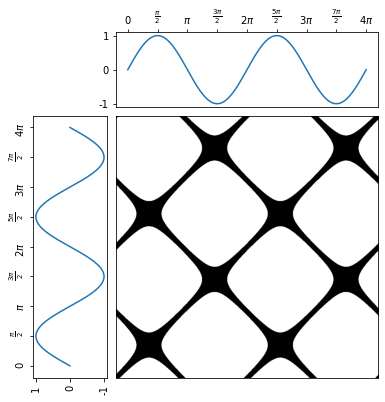

In [ ]:
# Author: Johann Faouzi <johann.faouzi@gmail.com>
# License: BSD-3-Clause

import numpy as np
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot


# Create a toy time series using the sine function
time_points = np.linspace(0, 4 * np.pi, 1000)
x = np.sin(time_points)
X = np.array([x])

# Recurrence plot transformation
rp = RecurrencePlot(threshold=np.pi/18)
X_rp = rp.transform(X)

# Plot the time series and its recurrence plot
fig = plt.figure(figsize=(6, 6))

gs = fig.add_gridspec(2, 2,  width_ratios=(2, 7), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Define the ticks and their labels for both axes
time_ticks = np.linspace(0, 4 * np.pi, 9)
time_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$',
                   r'$\frac{3\pi}{2}$', r'$2\pi$', r'$\frac{5\pi}{2}$',
                   r'$3\pi$', r'$\frac{7\pi}{2}$', r'$4\pi$']
value_ticks = [-1, 0, 1]
reversed_value_ticks = value_ticks[::-1]

# Plot the time series on the left with inverted axes
ax_left = fig.add_subplot(gs[1, 0])
ax_left.plot(x, time_points)
ax_left.set_xticks(reversed_value_ticks)
ax_left.set_xticklabels(reversed_value_ticks, rotation=90)
ax_left.set_yticks(time_ticks)
ax_left.set_yticklabels(time_ticklabels, rotation=90)
ax_left.invert_xaxis()

# Plot the time series on the top
ax_top = fig.add_subplot(gs[0, 1])
ax_top.plot(time_points, x)
ax_top.set_xticks(time_ticks)
ax_top.set_xticklabels(time_ticklabels)
ax_top.set_yticks(value_ticks)
ax_top.set_yticklabels(value_ticks)
ax_top.xaxis.tick_top()

# Plot the recurrence plot on the bottom right
ax_rp = fig.add_subplot(gs[1, 1])
ax_rp.imshow(X_rp[0], cmap='binary', origin='lower',
             extent=[0, 4 * np.pi, 0, 4 * np.pi])
ax_rp.set_xticks([])
ax_rp.set_yticks([])

plt.show()

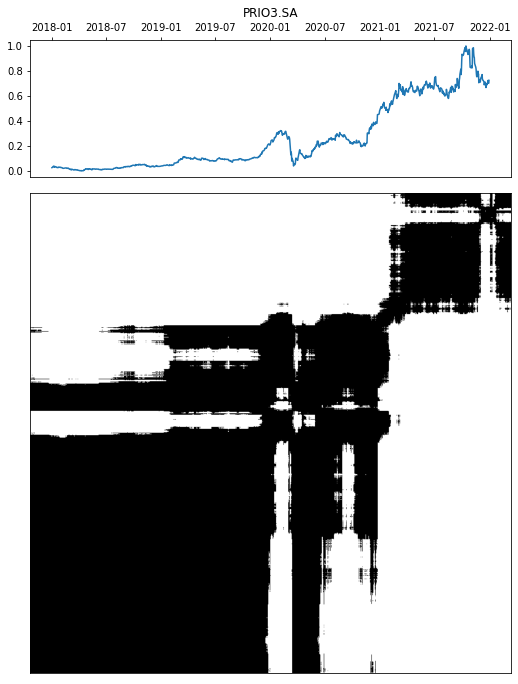

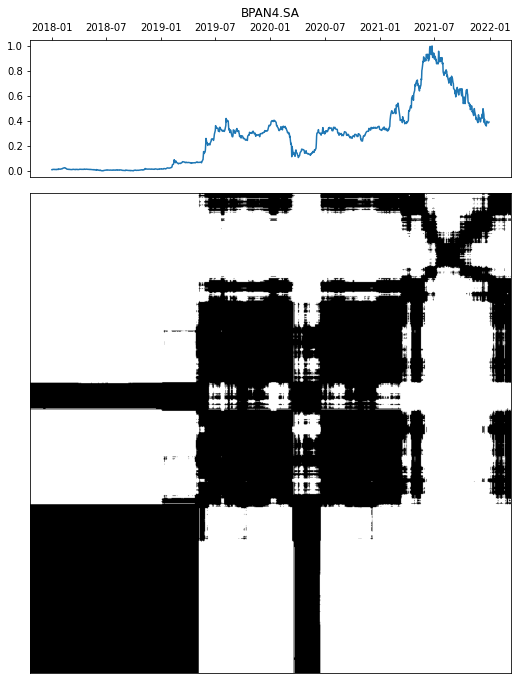

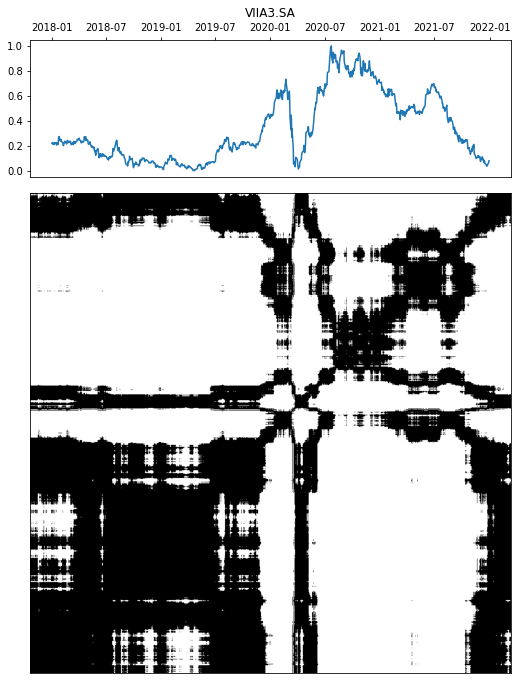

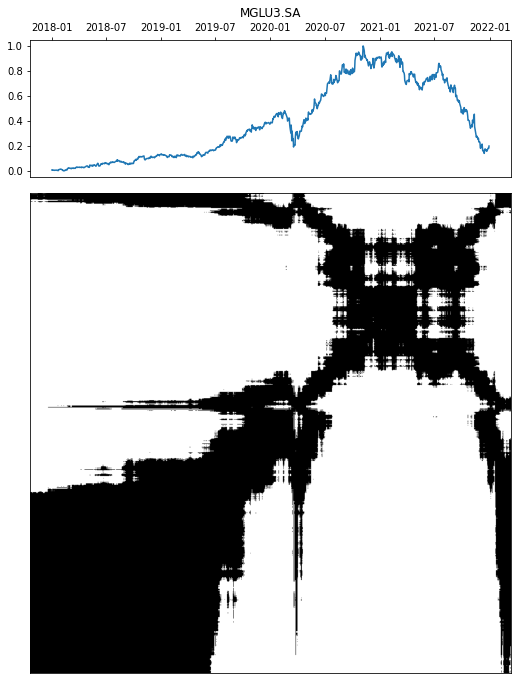

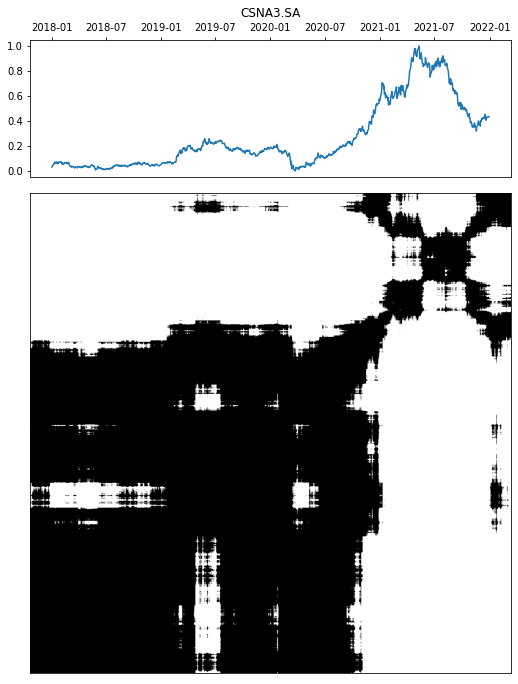

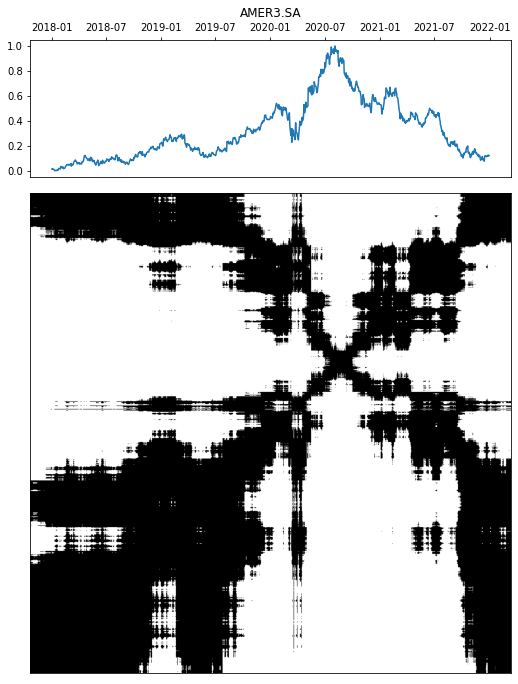

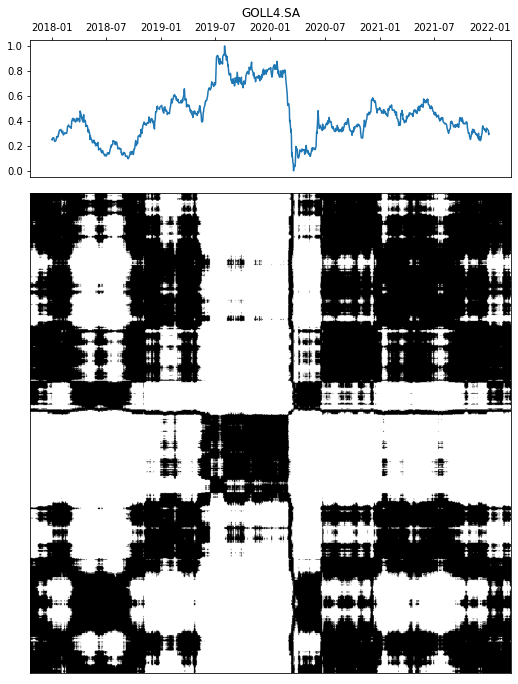

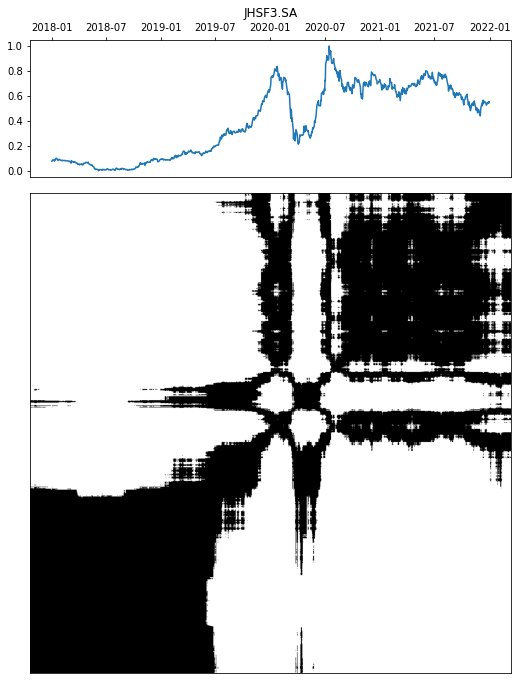

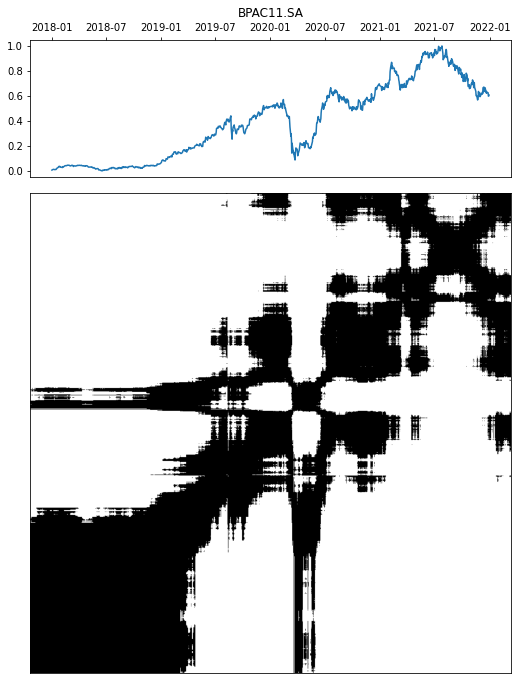

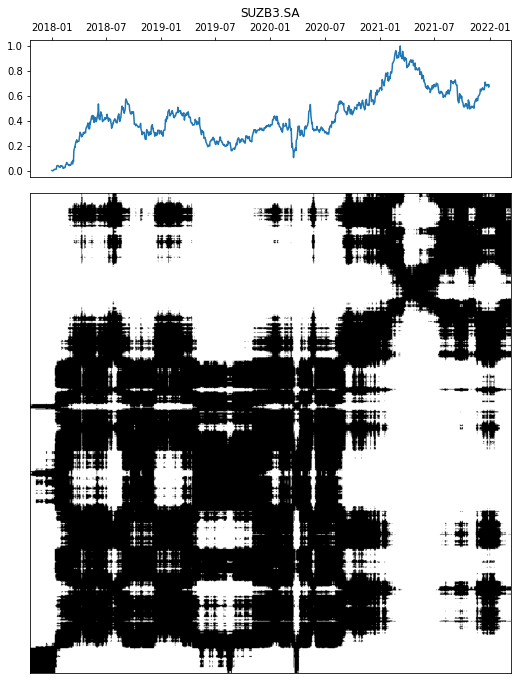

In [ ]:
for stock in best_10.columns:
  X = pd.DataFrame(best_10[stock].dropna().values).T.values

  # Recurrence plot transformation
  rp = RecurrencePlot(threshold=np.pi/18)
  X_rp = rp.transform(X)

  # Plot the time series and its recurrence plot
  fig = plt.figure(figsize=(11, 11))
  gs = fig.add_gridspec(2, 2,  width_ratios=(2, 7), height_ratios=(2, 7),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)

  ax_top = fig.add_subplot(gs[0, 1])
  plt.title(stock)
  ax_top.plot(best_10[stock])
  ax_top.xaxis.tick_top()

  # Plot the recurrence plot on the bottom right
  ax_rp = fig.add_subplot(gs[1, 1])
  ax_rp.imshow(X_rp[0], cmap='binary', origin='lower')
  ax_rp.set_xticks([])
  ax_rp.set_yticks([])
  plt.show()

In [ ]:
!pip install PyRQA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 99 kB 6.4 MB/s 
     |████████████████████████████████| 78 kB 8.4 MB/s 
     |████████████████████████████████| 887 kB 85.6 MB/s 
     |████████████████████████████████| 69 kB 8.1 MB/s 
  Created wheel for PyRQA: filename=PyRQA-8.0.0-py3-none-any.whl size=250250 sha256=4eb4e55a88ee568f7ff9e11c637de24bde687d0e79840090dc6805dfb6b1d8e9
  Stored in directory: /root/.cache/pip/wheels/2b/dc/0f/fc5e8a54ad6dd69a53bd657cd8bf51f26039764b1f68303a2d
  Created wheel for pytools: filename=pytools-2022.1.9-py2.py3-none-any.whl size=64666 sha256=64bfddc42d7577cb8c5121bc531b118bfe5c983ea1f6de6994006655cd0c77a3
  Stored in directory: /root/.cache/pip/wheels/11/d8/85/01a8cf50977badf2da880865124b159b112b861655a9b631d3
Successfully built PyRQA pytools


In [ ]:
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Classic
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation

for stock in best_10.columns:
  print('==================================',stock,'==================================')
  print('=============================================================================')
  data_points = best_10[stock].values
  time_series = TimeSeries(data_points,
                          embedding_dimension=2,
                          time_delay=2)
  settings = Settings(time_series,
                      analysis_type=Classic,
                      neighbourhood=FixedRadius(0.65),
                      similarity_measure=EuclideanMetric,
                      theiler_corrector=1)
  computation = RQAComputation.create(settings,verbose=True)
  result = computation.run()
  result.min_diagonal_line_length = 2
  result.min_vertical_line_length = 2
  result.min_white_vertical_line_length = 2
  print(result)

================================== PRIO3.SA ==================================
[Platform 'NVIDIA CUDA']
Vendor: NVIDIA Corporation
Version: OpenCL 1.2 CUDA 11.2.109
Profile: FULL_PROFILE
Extensions: cl_khr_global_int32_base_atomics cl_khr_global_int32_extended_atomics cl_khr_local_int32_base_atomics cl_khr_local_int32_extended_atomics cl_khr_fp64 cl_khr_byte_addressable_store cl_khr_icd cl_nv_compiler_options cl_nv_device_attribute_query cl_nv_pragma_unroll cl_nv_copy_opts cl_nv_create_buffer cl_khr_int64_base_atomics cl_khr_int64_extended_atomics cl_nv_kernel_attribute cl_khr_device_uuid


[Device 'Tesla V100-SXM2-16GB']
Vendor: NVIDIA Corporation
Type: 4
Version: OpenCL 1.2 CUDA
Profile: FULL_PROFILE
Max Clock Frequency: 1530
Global Mem Size: 16945512448
Address Bits: 64
Max Compute Units: 80
Max Work Group Size: 1024
Max Work Item Dimensions: 3
Max Work Item Sizes: [1024, 1024, 64]
Local Mem Size: 49152
Max Mem Alloc Size: 4236378112
Extensions: cl_khr_global_int32_base_atomics cl_k

In [ ]:
#RQA ao longo do tempo
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Classic
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation

for time_space in range(500,len(best_10)):
  stock = 'BPAC11.SA'
  print('==================================',best_10.reset_index()['Date'].iloc[time_space],'==================================')
  print('=============================================================================')
  data_points = best_10[stock].loc[(best_10.index <= best_10.reset_index()['Date'].iloc[time_space]) & (best_10.index >= best_10.reset_index()['Date'].iloc[time_space-500])].values
  time_series = TimeSeries(data_points,
                          embedding_dimension=2,
                          time_delay=2)
  settings = Settings(time_series,
                      analysis_type=Classic,
                      neighbourhood=FixedRadius(0.65),
                      similarity_measure=EuclideanMetric,
                      theiler_corrector=1)
  computation = RQAComputation.create(settings,verbose=True)
  result = computation.run()
  result.min_diagonal_line_length = 2
  result.min_vertical_line_length = 2
  result.min_white_vertical_line_length = 2
  print(result)

Streaming output truncated to the last 5000 lines.
Ratio laminarity / determinism (LAM/DET): 1.000532

================================== 2021-08-10 00:00:00 ==================================
[Platform 'NVIDIA CUDA']
Vendor: NVIDIA Corporation
Version: OpenCL 1.2 CUDA 11.2.109
Profile: FULL_PROFILE
Extensions: cl_khr_global_int32_base_atomics cl_khr_global_int32_extended_atomics cl_khr_local_int32_base_atomics cl_khr_local_int32_extended_atomics cl_khr_fp64 cl_khr_byte_addressable_store cl_khr_icd cl_nv_compiler_options cl_nv_device_attribute_query cl_nv_pragma_unroll cl_nv_copy_opts cl_nv_create_buffer cl_khr_int64_base_atomics cl_khr_int64_extended_atomics cl_nv_kernel_attribute cl_khr_device_uuid


[Device 'Tesla V100-SXM2-16GB']
Vendor: NVIDIA Corporation
Type: 4
Version: OpenCL 1.2 CUDA
Profile: FULL_PROFILE
Max Clock Frequency: 1530
Global Mem Size: 16945512448
Address Bits: 64
Max Compute Units: 80
Max Work Group Size: 1024
Max Work Item Dimensions: 3
Max Work Item Sizes: [1024

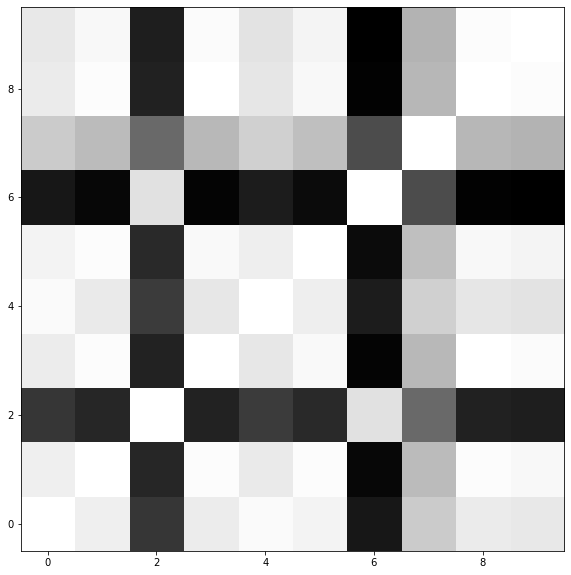

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot

# Parameters
#n_samples, n_features = 100, 144

# Toy dataset
#rng = np.random.RandomState(41)
#X = rng.randn(n_samples, n_features)
X = best_10.dropna().values
# Recurrence plot transformation
rp = RecurrencePlot(dimension=1,
                    percentage=20)
X_rp = rp.fit_transform(X) 

# Show the results for the first time series
plt.figure(figsize=(10, 10))
plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.show() 